# Кластеризация & метрики качества

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)
import warnings
warnings.filterwarnings('ignore')

### Данные

в sklearn.datasets есть разные наборы данных, можно выбрать другие

In [2]:
from sklearn.datasets import make_moons

In [3]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
X_moon = X
y_moon = y

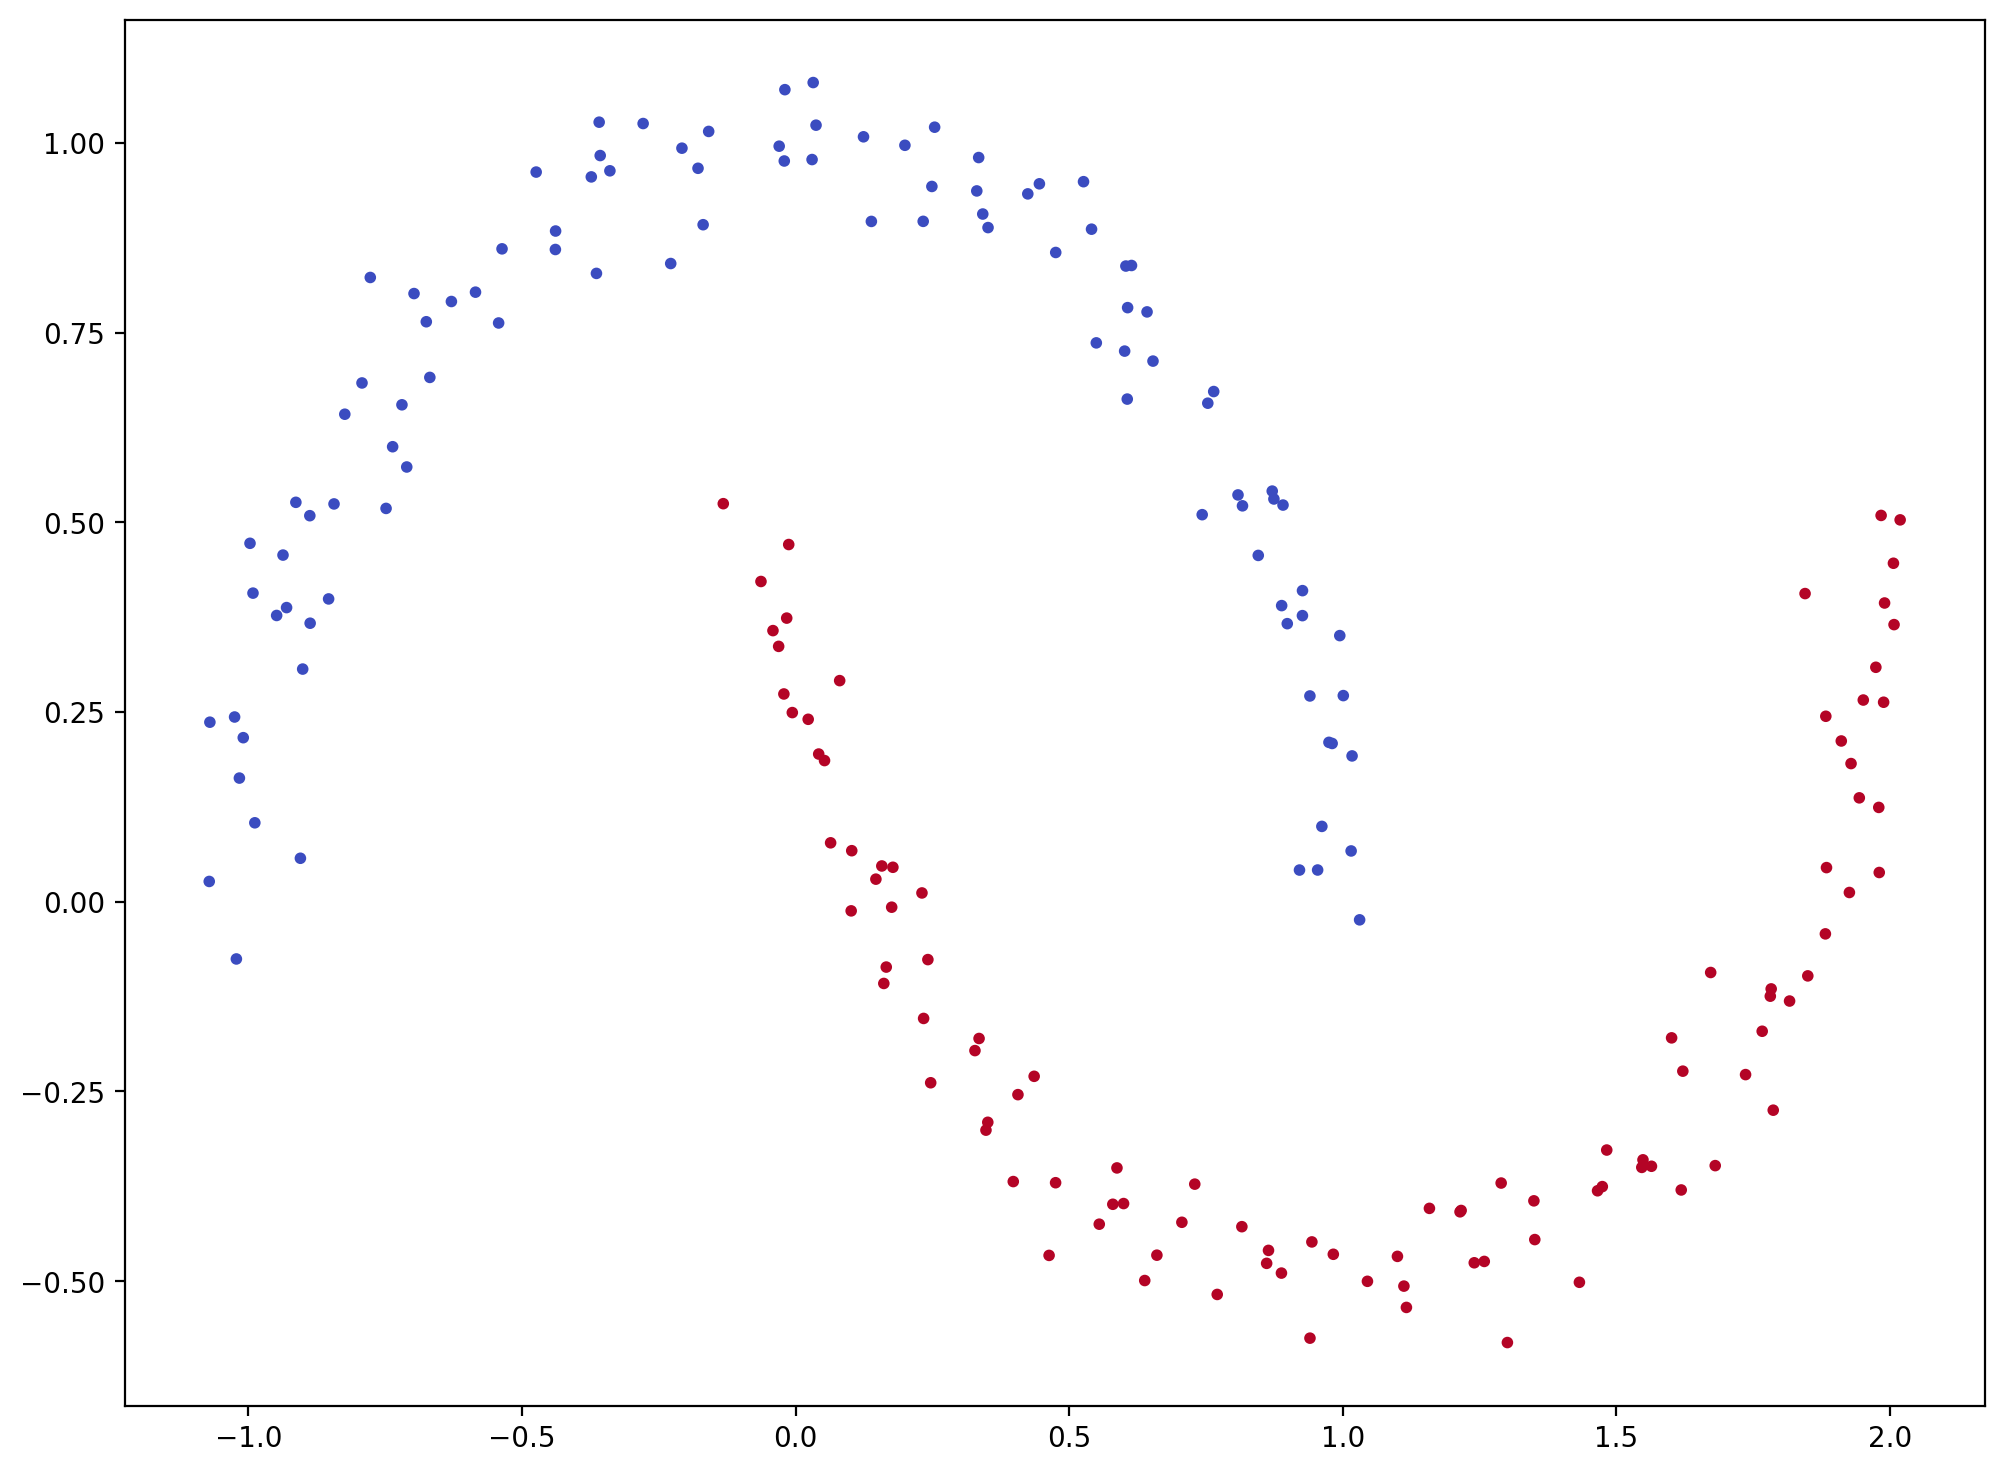

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=10);

приведём данные по обеим осям к нормальному распределению

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

форма осталась, но диапазоны выровнялись:

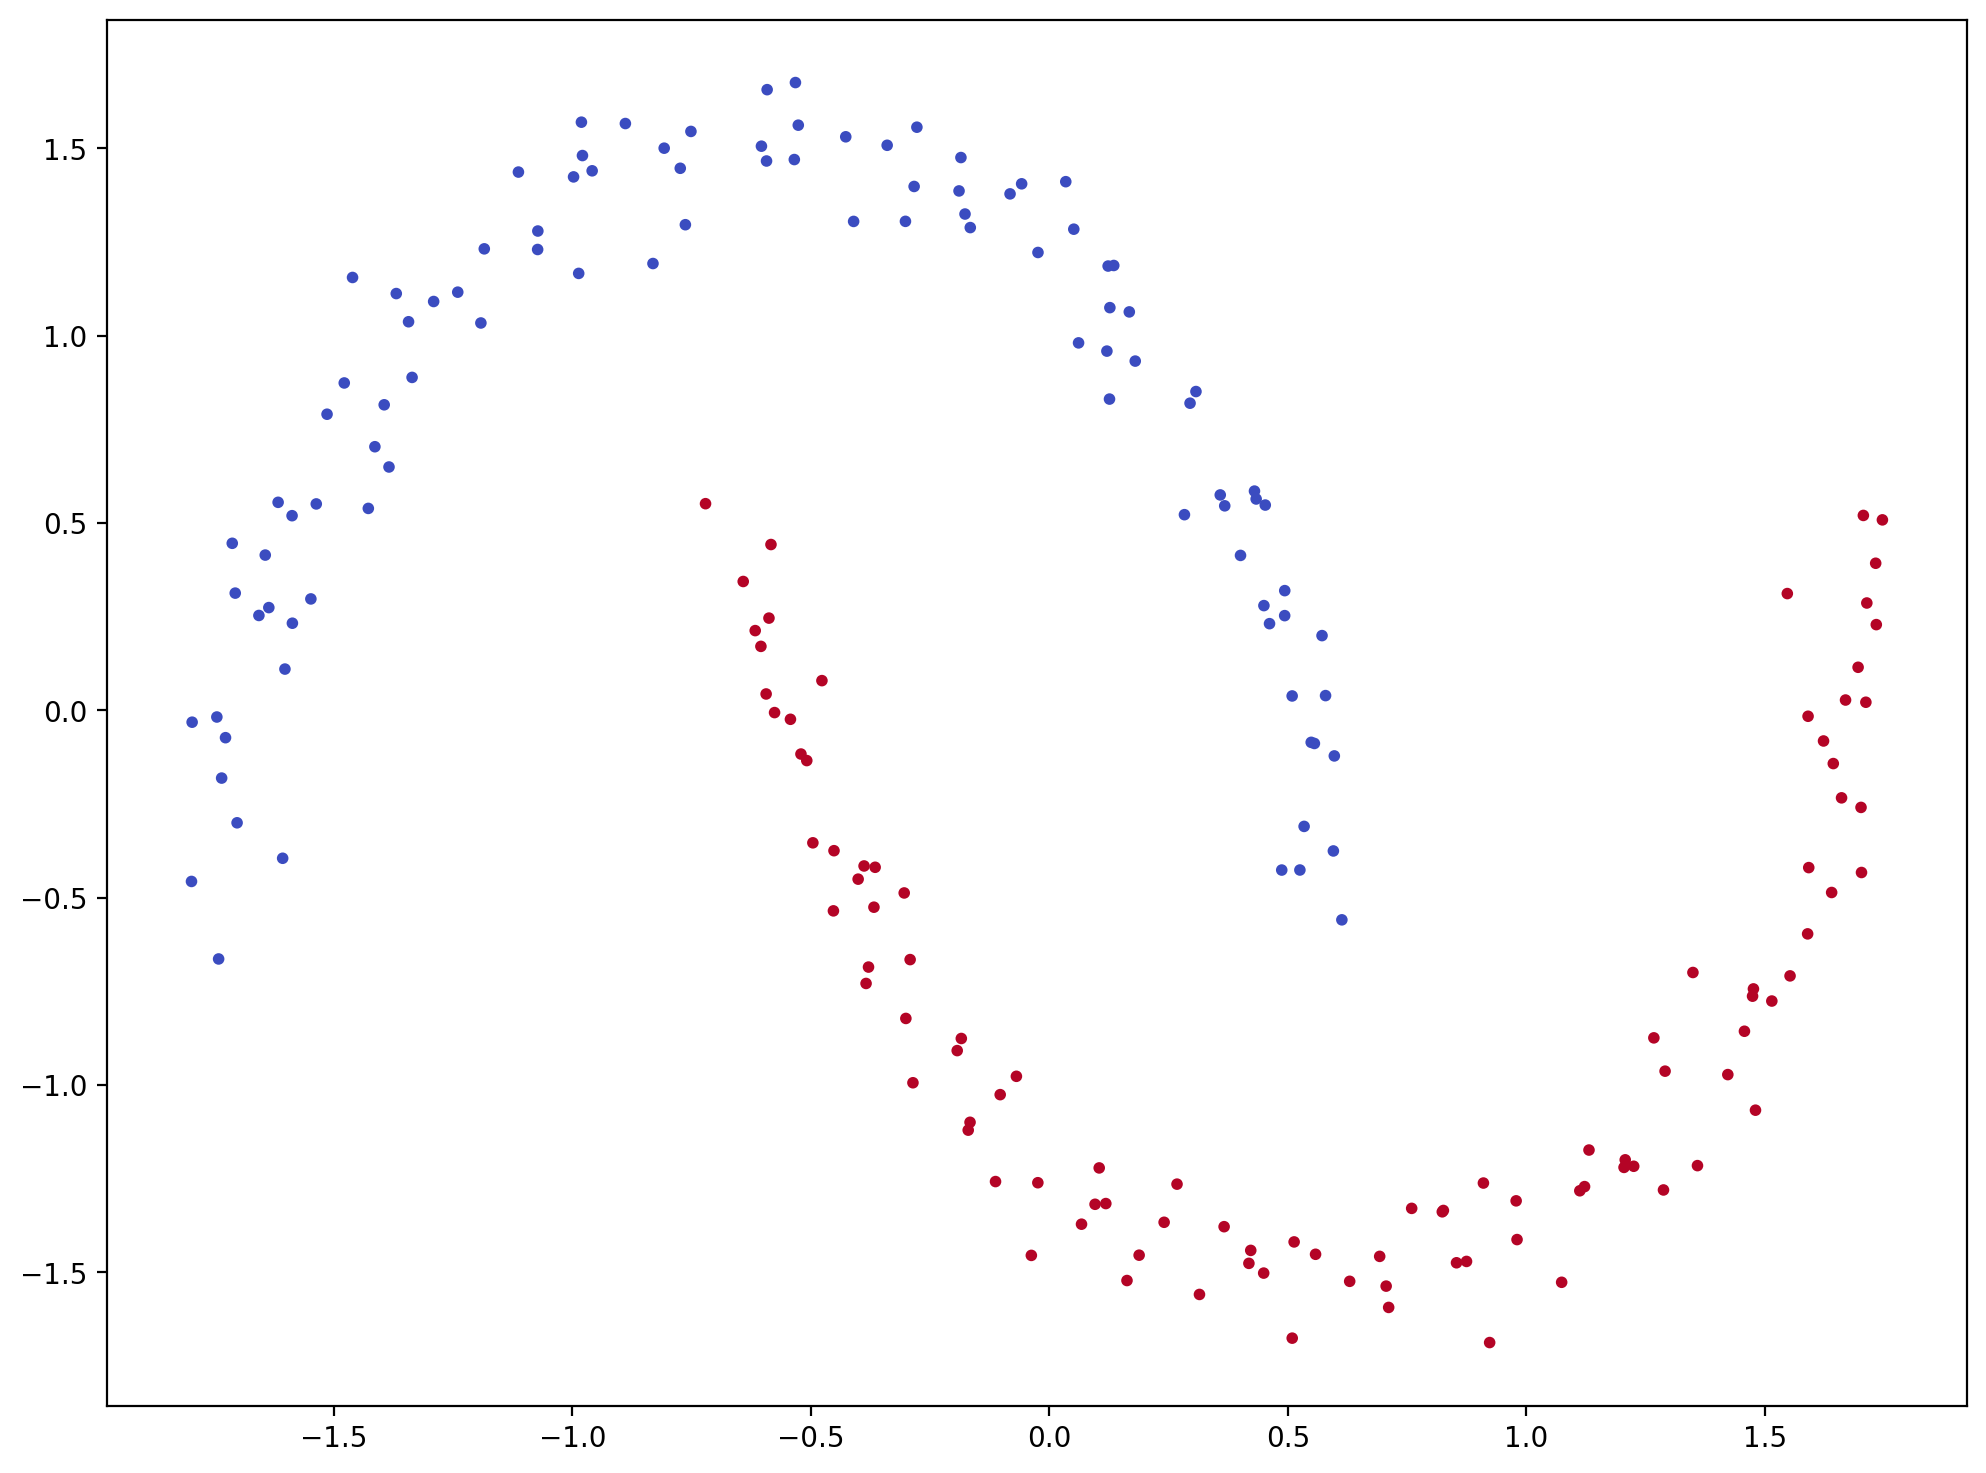

In [6]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='coolwarm', s=10);

### Кластеризация

теперь кластеризуем с помощью различных методов

In [7]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [8]:
algorithms = [
    AffinityPropagation(),
    KMeans(n_clusters=2),
    AgglomerativeClustering(n_clusters=2),
    DBSCAN(),
]

сделаем случайное предсказание

In [9]:
clusters_random = np.random.randint(low=0, high=2, size=len(X))
print(clusters_random)


[0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1
 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0
 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1
 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1]


и функцию-заготовку, которая считает 2 метрики качества и генерирует заголовки для графиков

In [10]:
def get_descr(algo_name, y, y_pred, X):
    return f"{algo_name}\nARI {adjusted_rand_score(y, y_pred):.2f}\nSilhouette {silhouette_score(X, y_pred):.2f}"

проследите за ростом ARI и за падением Silhouette (хотя этот показатель по своему назначению тоже должен расти):  

Adjusted Rand Score (ARI) is a metric used to evaluate the quality of clustering results by comparing the clustering output with some ground truth labels or a priori information about the data. It measures the similarity between the true labels and the predicted labels, taking into account the chance agreement between the two sets of labels.

The ARI ranges from -1 to 1, where a score of 1 indicates perfect agreement between the true and predicted labels, a score of 0 indicates that the clustering output is no better than random, and a score of -1 indicates complete disagreement between the true and predicted labels.

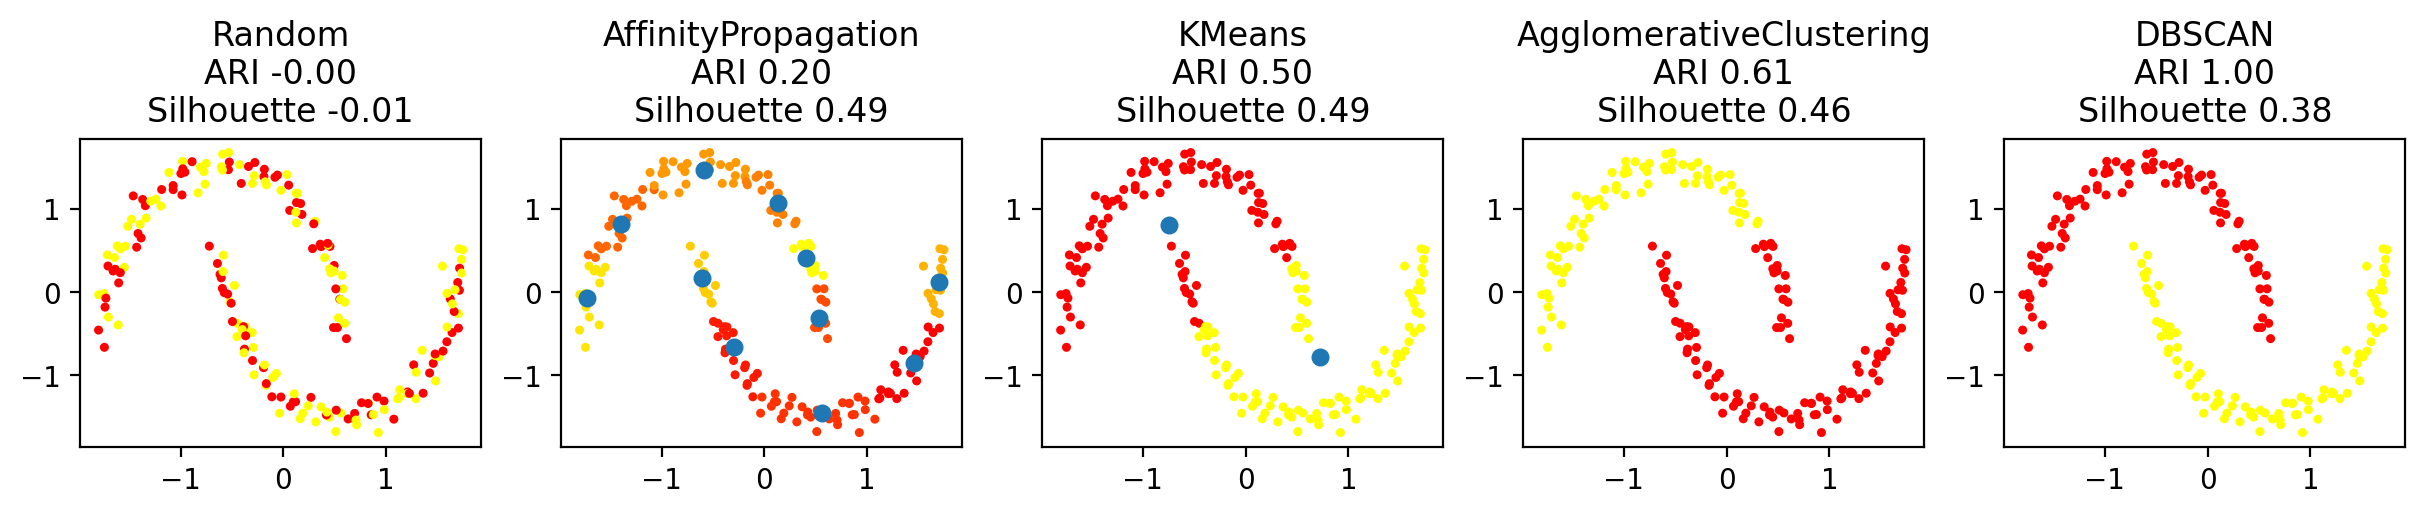

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2))

# plot random clusters
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_random, cmap='autumn', s=5)
axes[0].set_title(get_descr("Random", y, clusters_random, X_scaled))

# plot algorithms
for ax, algorithm in zip(axes[1:], algorithms): # iterate over axes and algorithms
    # кластеризуем и выводим картинку
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='autumn', s=5)
    ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, X_scaled))
    
    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=30)

# Подбор количества кластеров для KMeans

KMeans минимизирует сумму квадратов расстояний объектов классов до их центроидов.  
В обученном классификаторе это значение находится в поле `inertia_`

Посчитаем значения inertia при разном количестве кластеров. Они объективно стремятся к нулю с ростом числа кластеров (предельный случай: каждый объект - кластер, расстояние = 0)

In [12]:
k_inertia = []
clusters_range = range(1,31)

for k in clusters_range:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    # inertia_ —
    # Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
    k_inertia.append(clf_kmeans.inertia_)

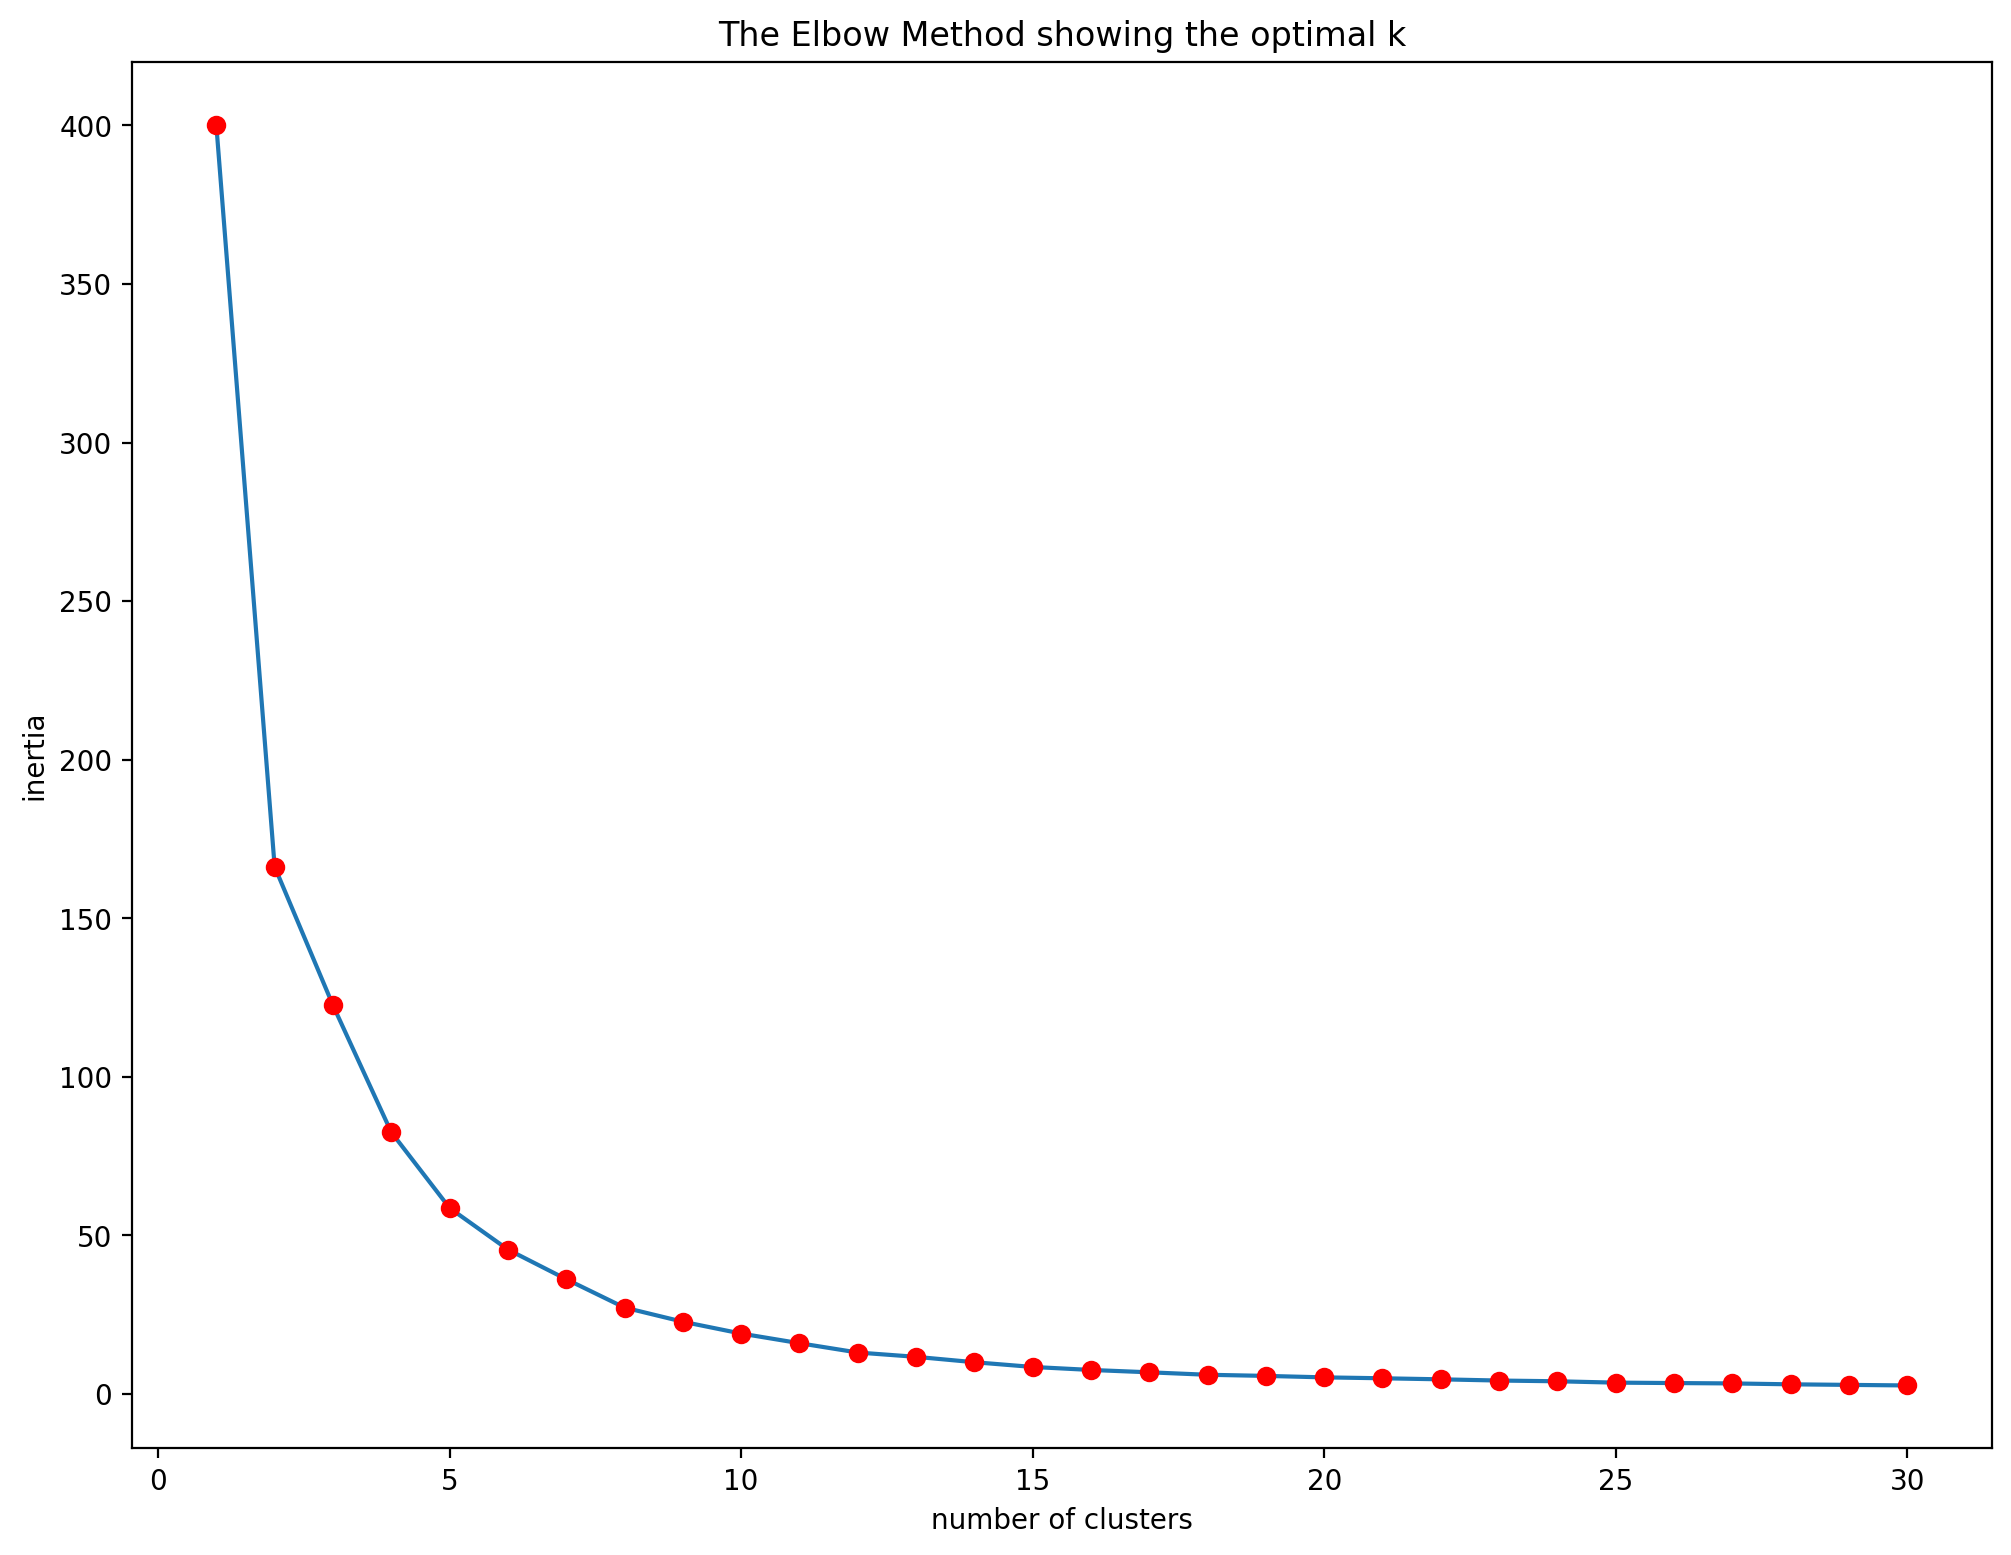

In [13]:
plt.plot(clusters_range, k_inertia)
plt.plot(clusters_range, k_inertia, 'ro')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Как подобрать оптимальное значение? Будем на каждом шаге смотреть изменение inertia, и в тот момент, когда оно резко замедлится (относительно предыдущего изменения) мы и остановимся

Для начала считаем сами изменения

### $${inertia_{k+1}-inertia_{k}}$$

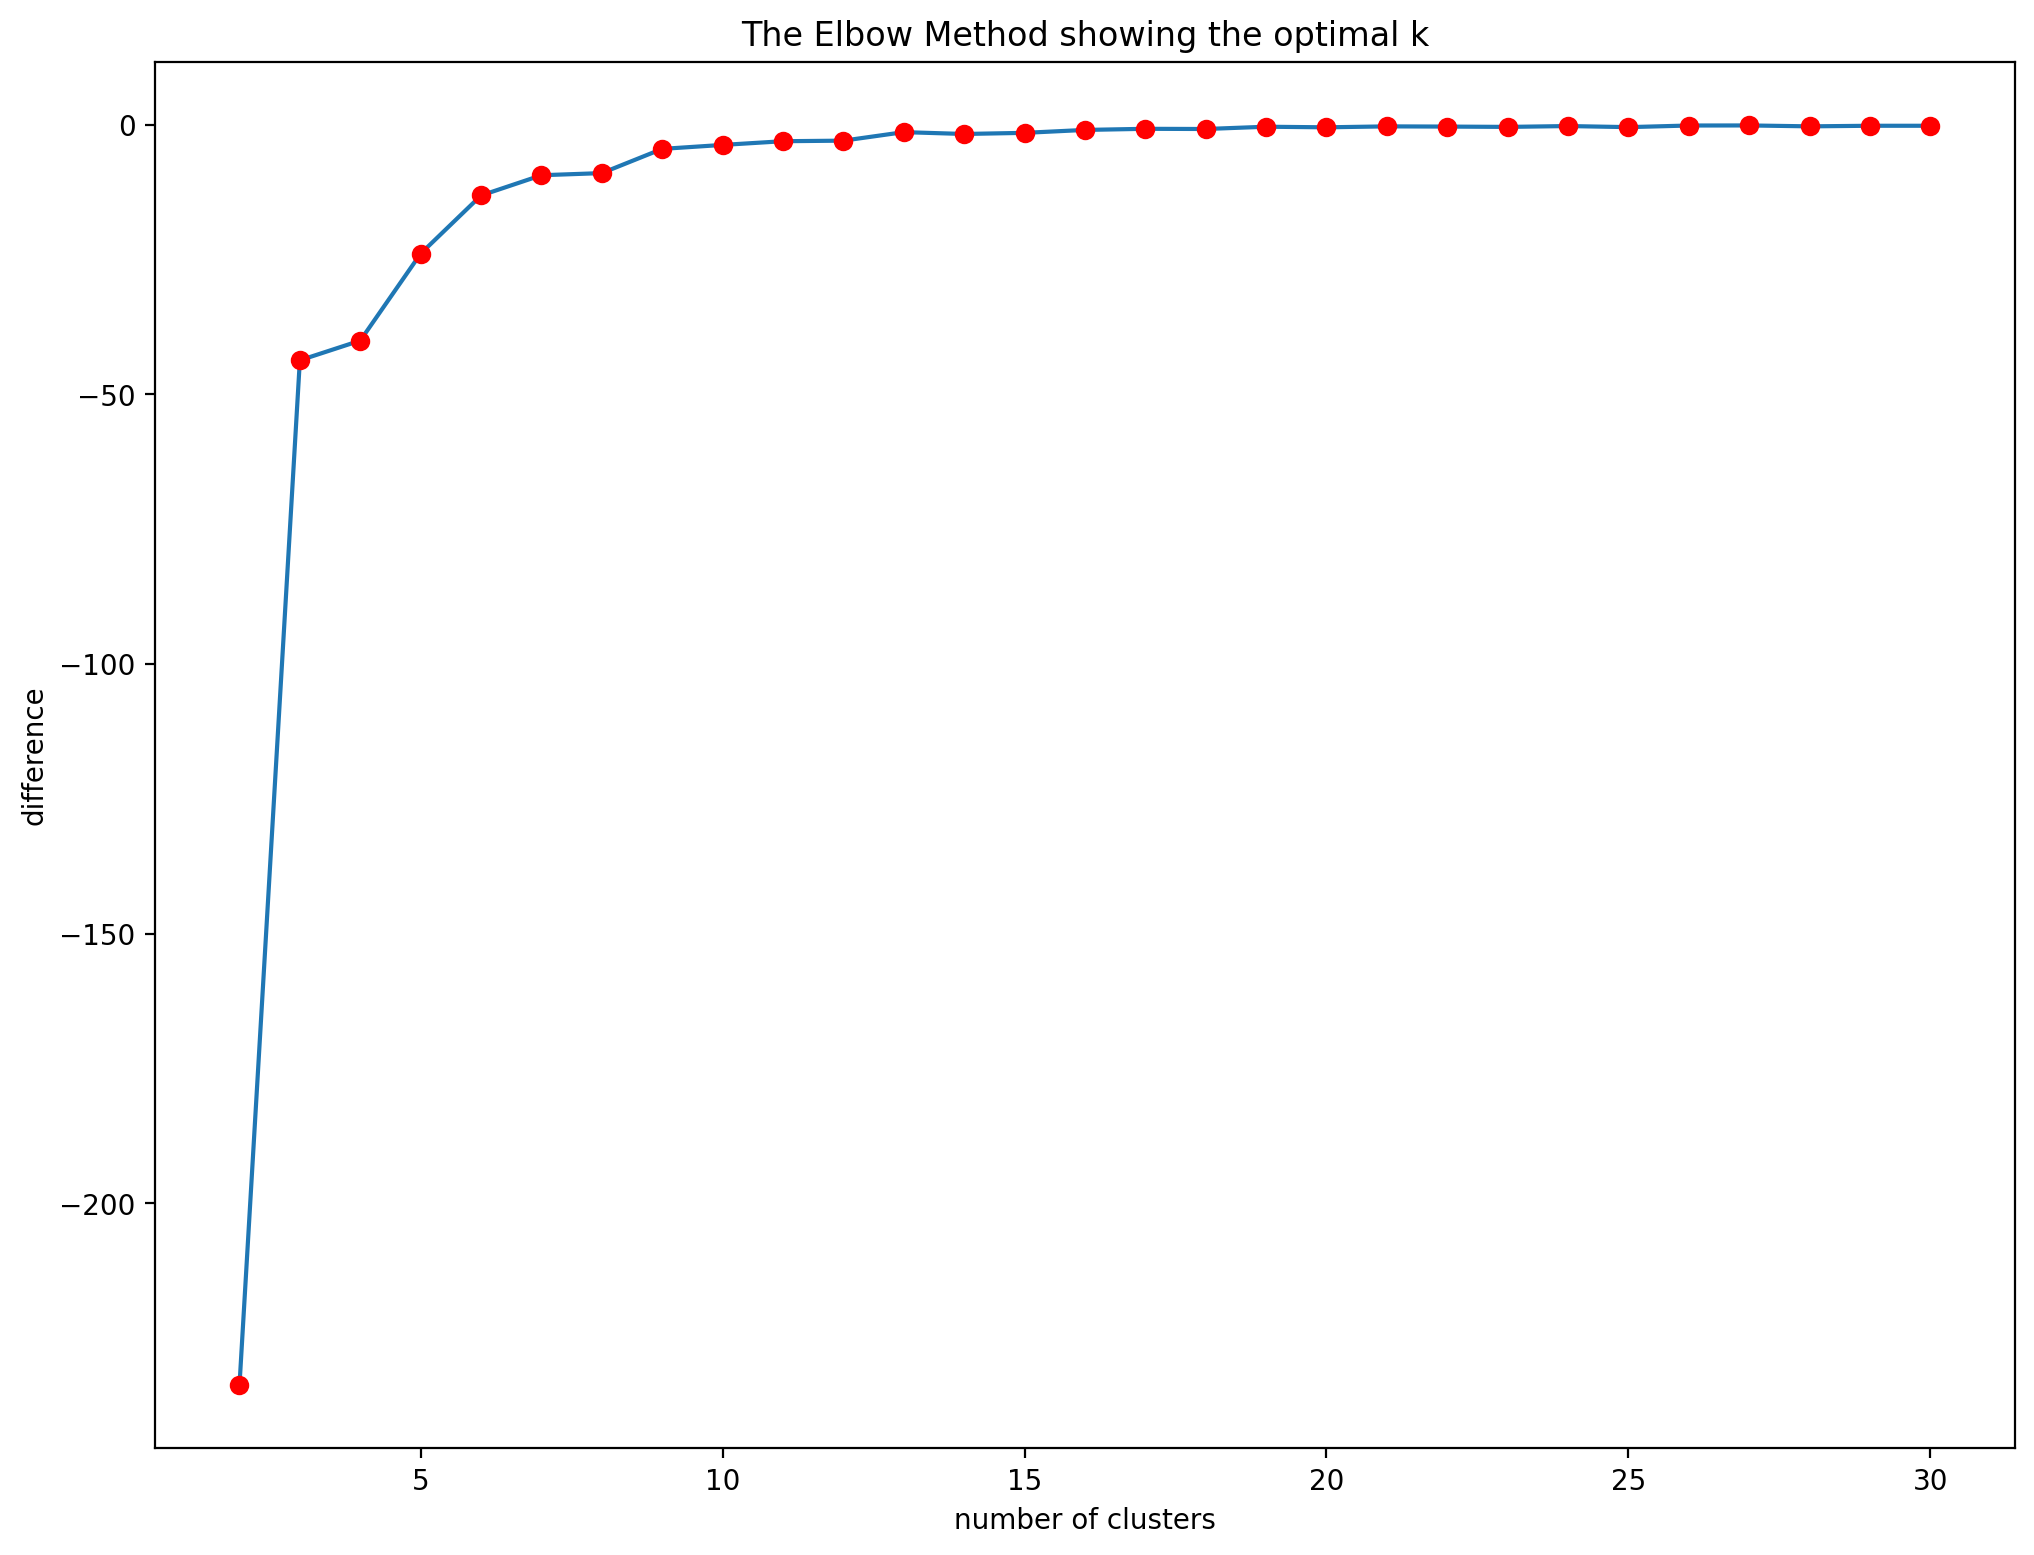

In [14]:
diff = np.diff(k_inertia) # array of differences between each consecutive pair of elements

plt.plot(clusters_range[1:], diff) # from second element as diff is one element shorter than clusters_range
plt.plot(clusters_range[1:], diff, 'ro')
plt.xlabel('number of clusters')
plt.ylabel('difference')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Теперь можно найти оптимальное число кластеров по этой формуле:

### $$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [15]:
# array of ratios of differences between each consecutive pair of elements
# numerator is diff[1:] as we are skipping first element, denominator is diff[:-1] as we are skipping last element
diff_ratio = diff[1:] / diff[:-1]

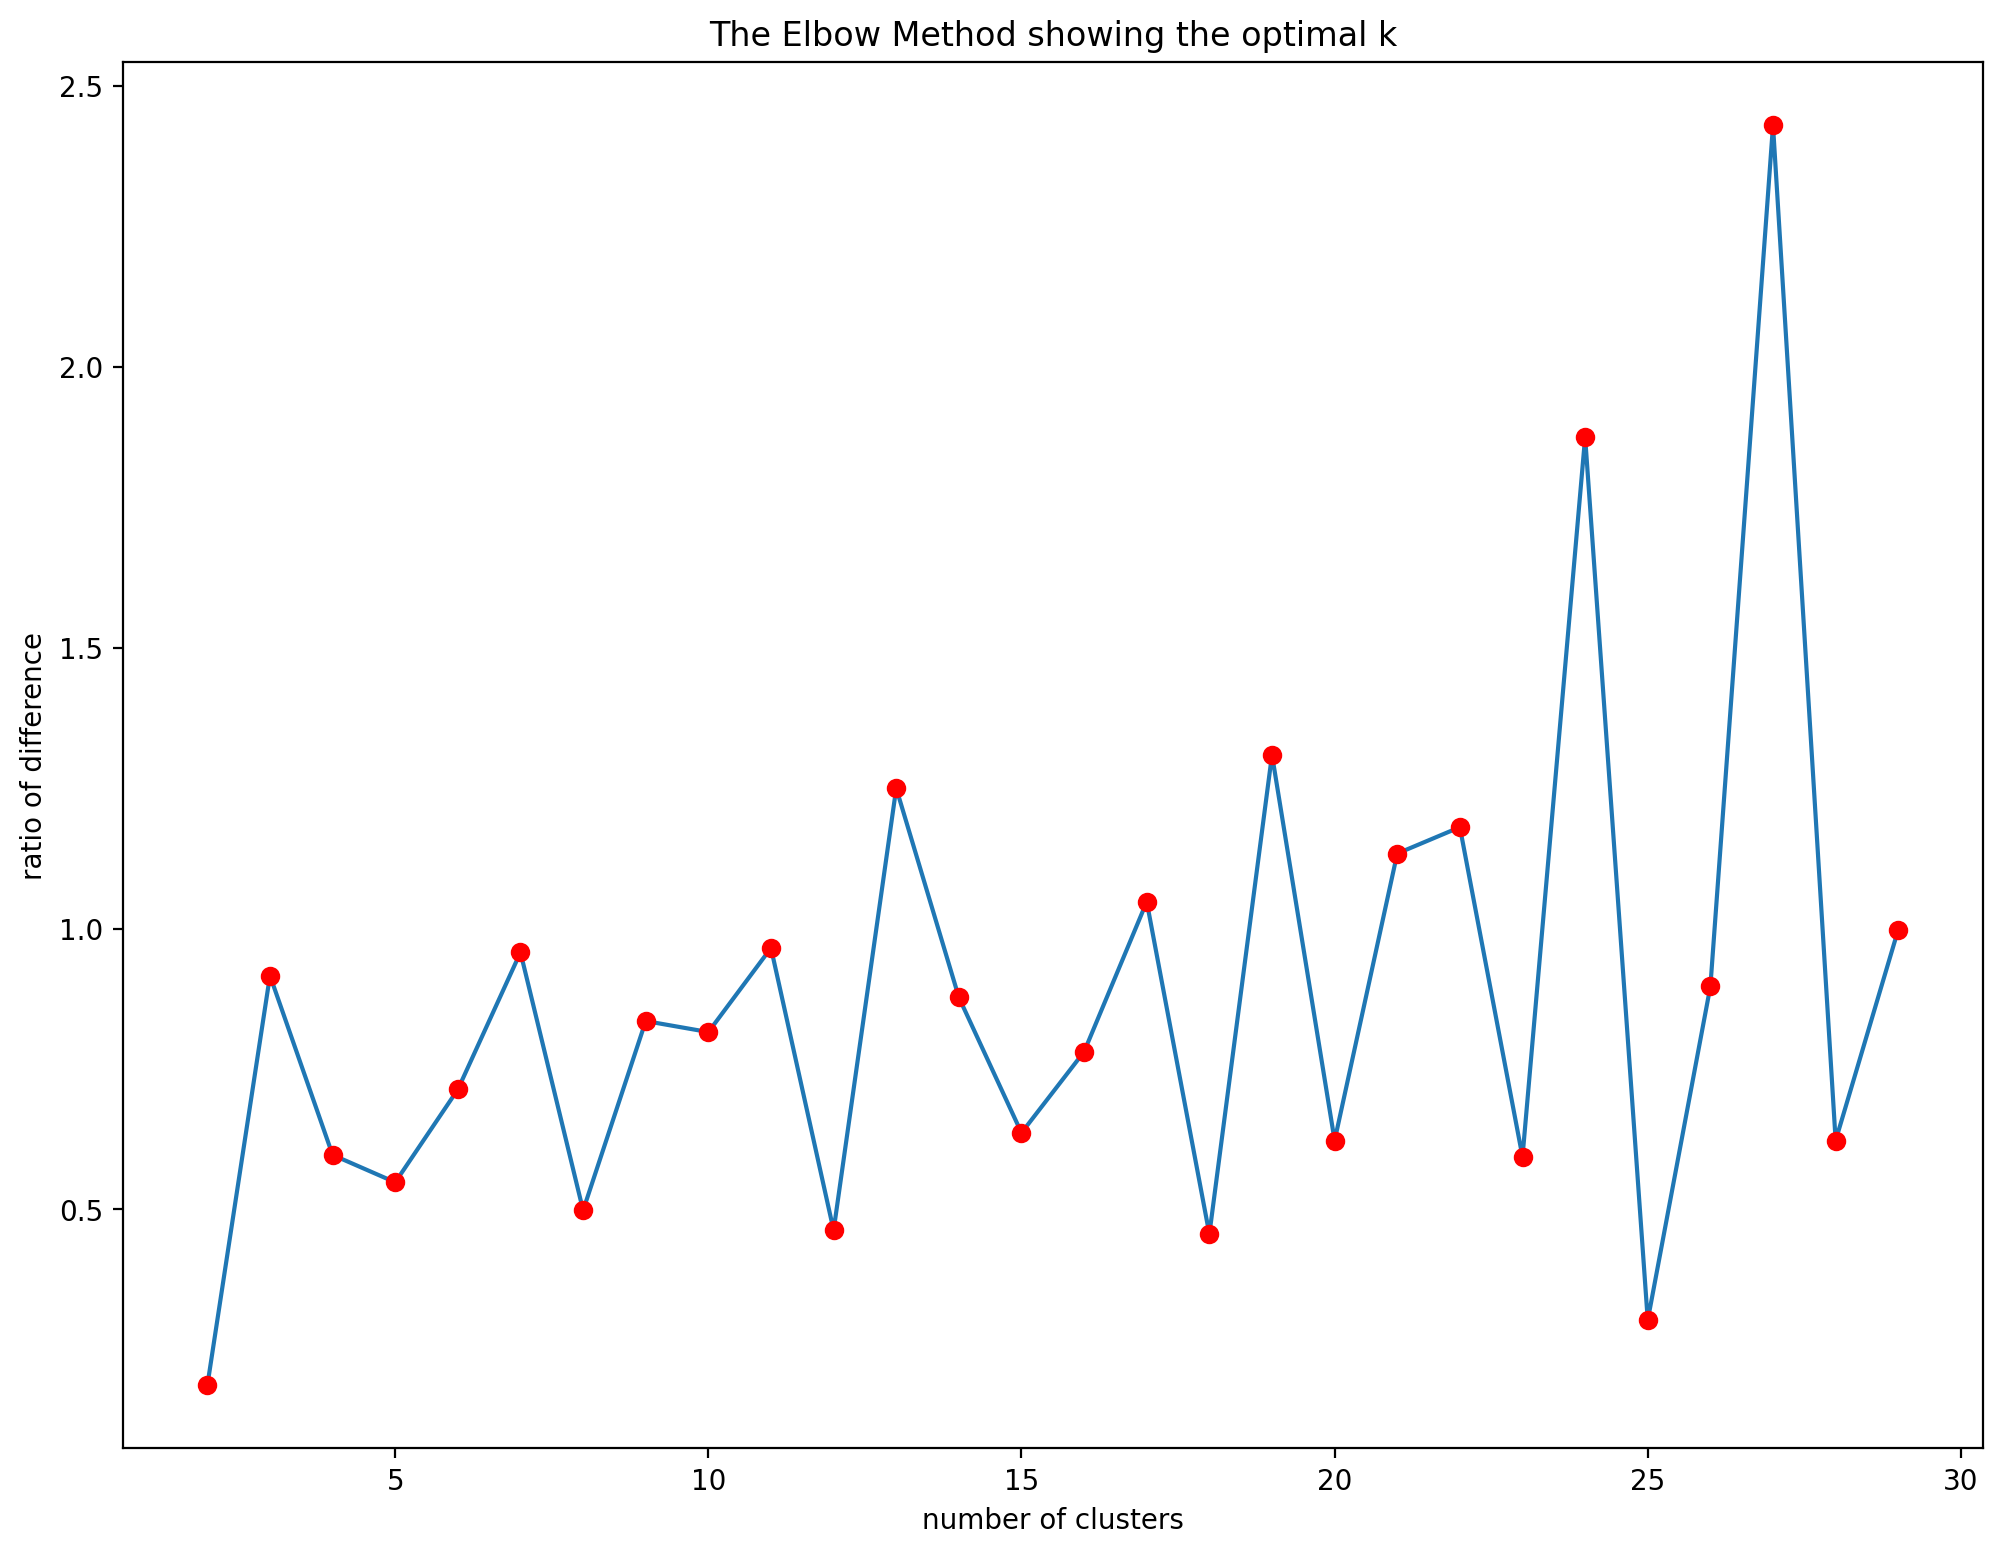

In [16]:
plt.plot(clusters_range[1:-1], diff_ratio)      # from second element to the one before last as diff_ratio is two elements shorter than clusters_range
plt.plot(clusters_range[1:-1], diff_ratio, 'ro')
plt.xlabel('number of clusters')
plt.ylabel('ratio of difference')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [17]:
diff_ratio

array([0.18680484, 0.91633791, 0.59709718, 0.54839643, 0.71362789,
       0.95769278, 0.49844851, 0.83538911, 0.8158187 , 0.96548773,
       0.46291689, 1.24982211, 0.87752679, 0.63644202, 0.78083697,
       1.04777573, 0.45619856, 1.30932704, 0.62270205, 1.13357823,
       1.18050731, 0.59366527, 1.87478639, 0.30295806, 0.89702921,
       2.42954985, 0.62274232, 0.99824104])

In [20]:
# argmin- Returns the indices of the minimum values along an axis.
# +1 as diff_ratio calculated from second element (n+1) while clusters_range from 1 (n)
k_opt = clusters_range[np.argmin(diff_ratio)+1] 
k_opt

2

### Дендрограмма

In [21]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    '''Create linkage matrix and then plot the dendrogram'''

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    # children_ - array of children of each non-leaf node. 
    # Values less than n_samples correspond to leaves of the tree which are the original samples. 
    # A node i greater than or equal to n_samples is a non-leaf node and has children tree.children_[i - n_samples]. 
    # Alternatively at the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_): 
        current_count = 0
        for child_idx in merge: # merge - array of pairs.
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data



## Plot dendrograms with different linkage attribute (single, average, complete, ward)

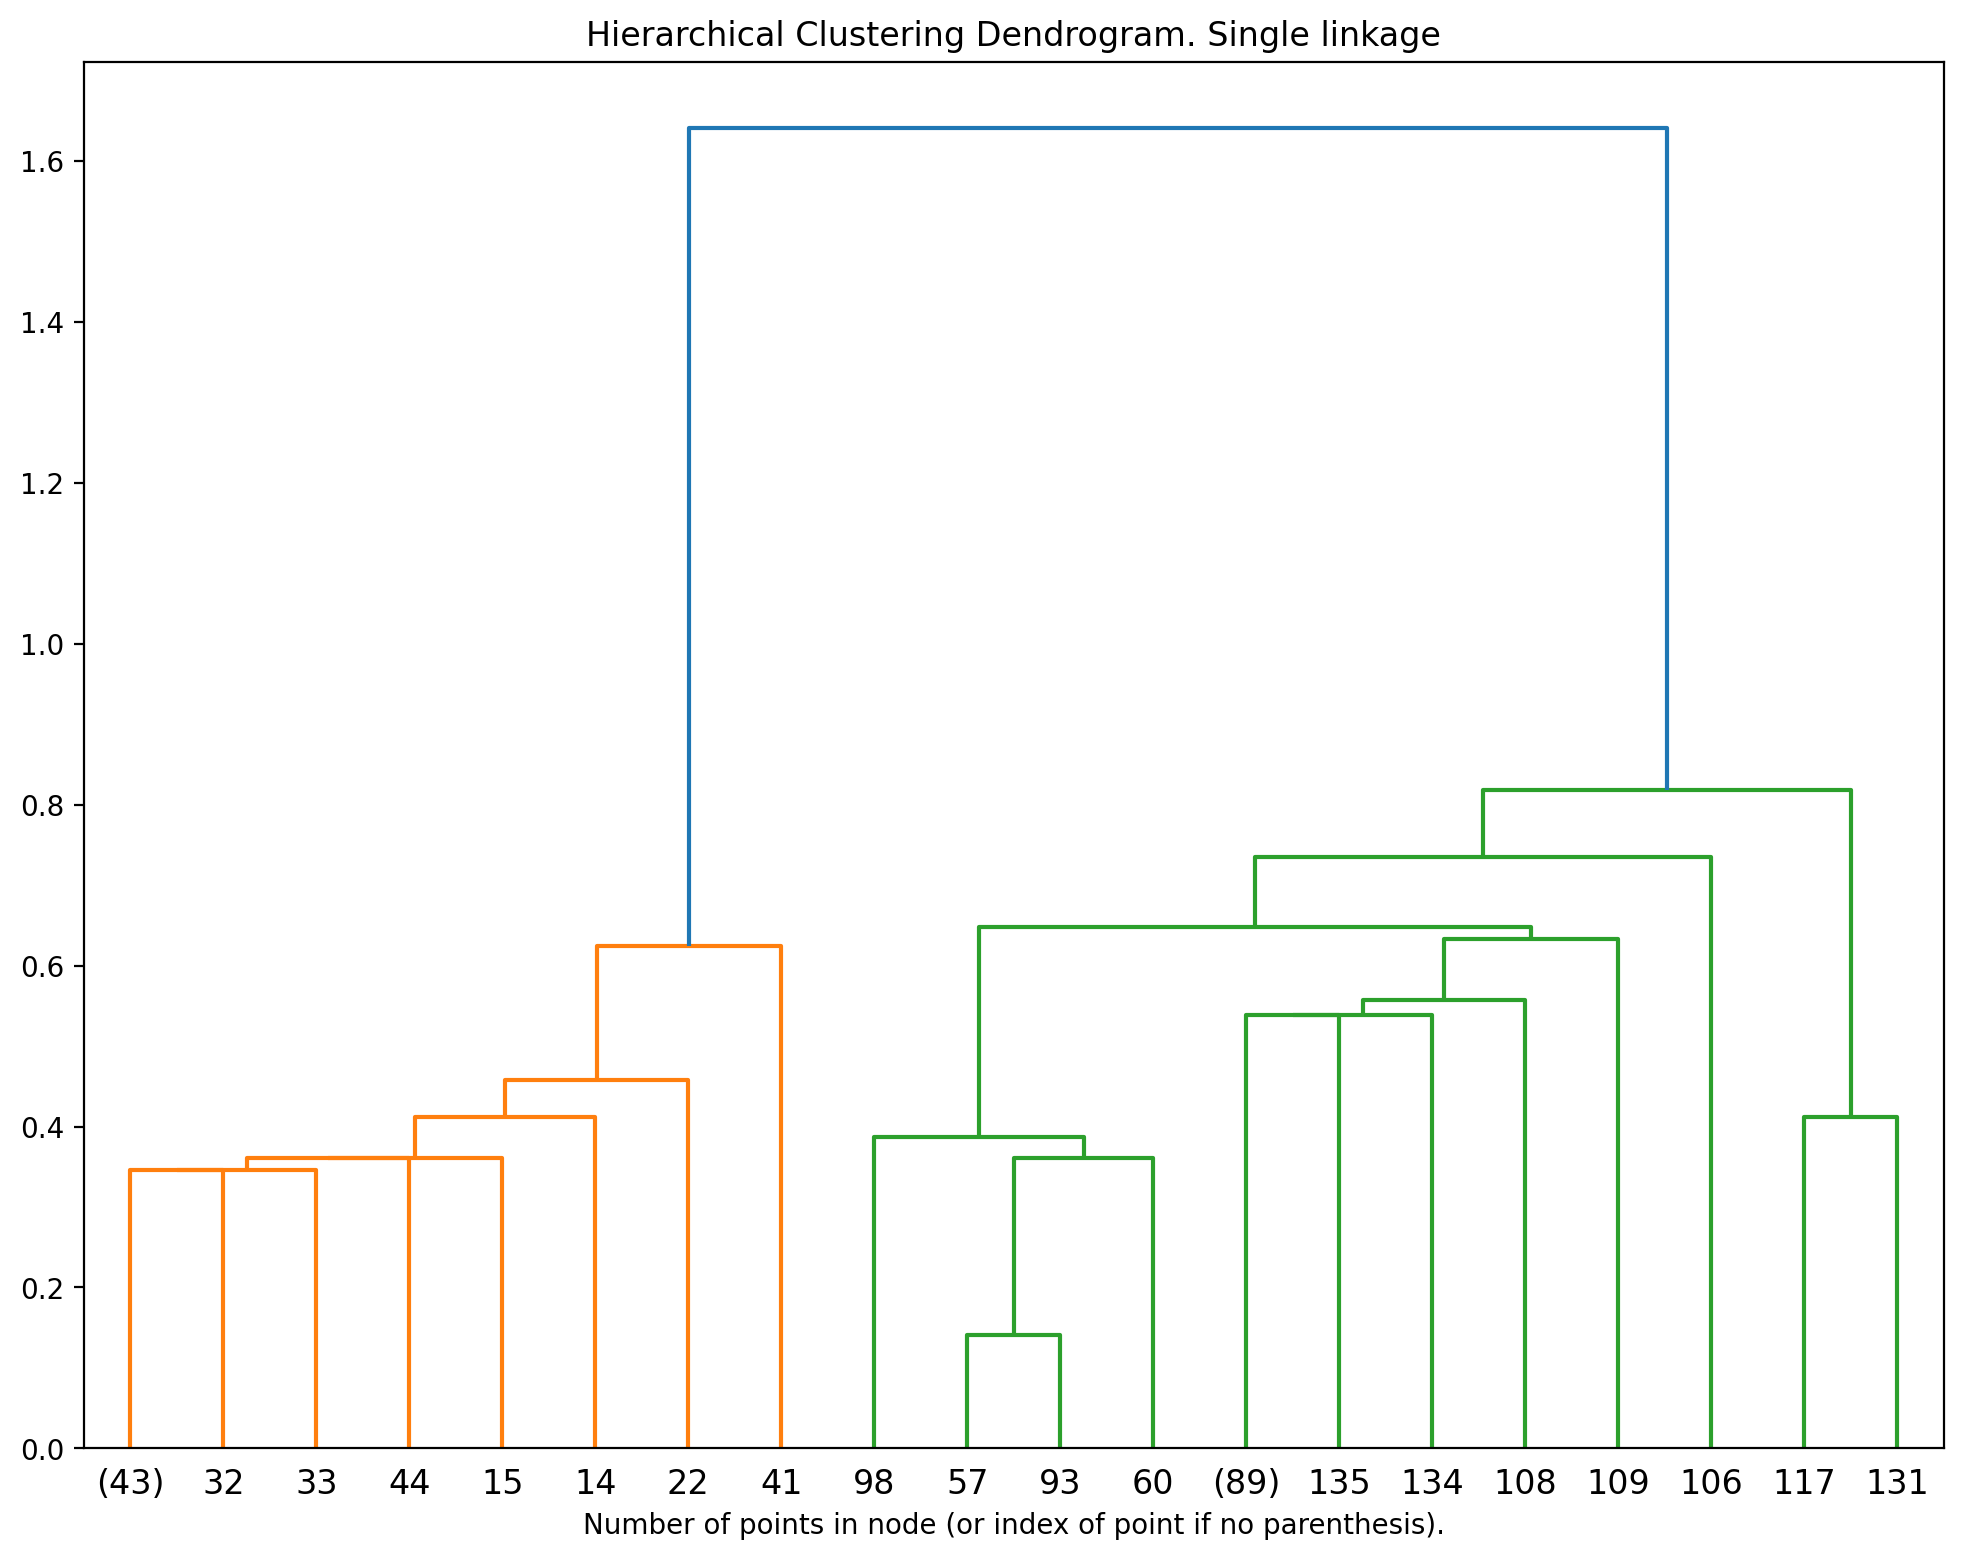

In [22]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram. Single linkage')
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

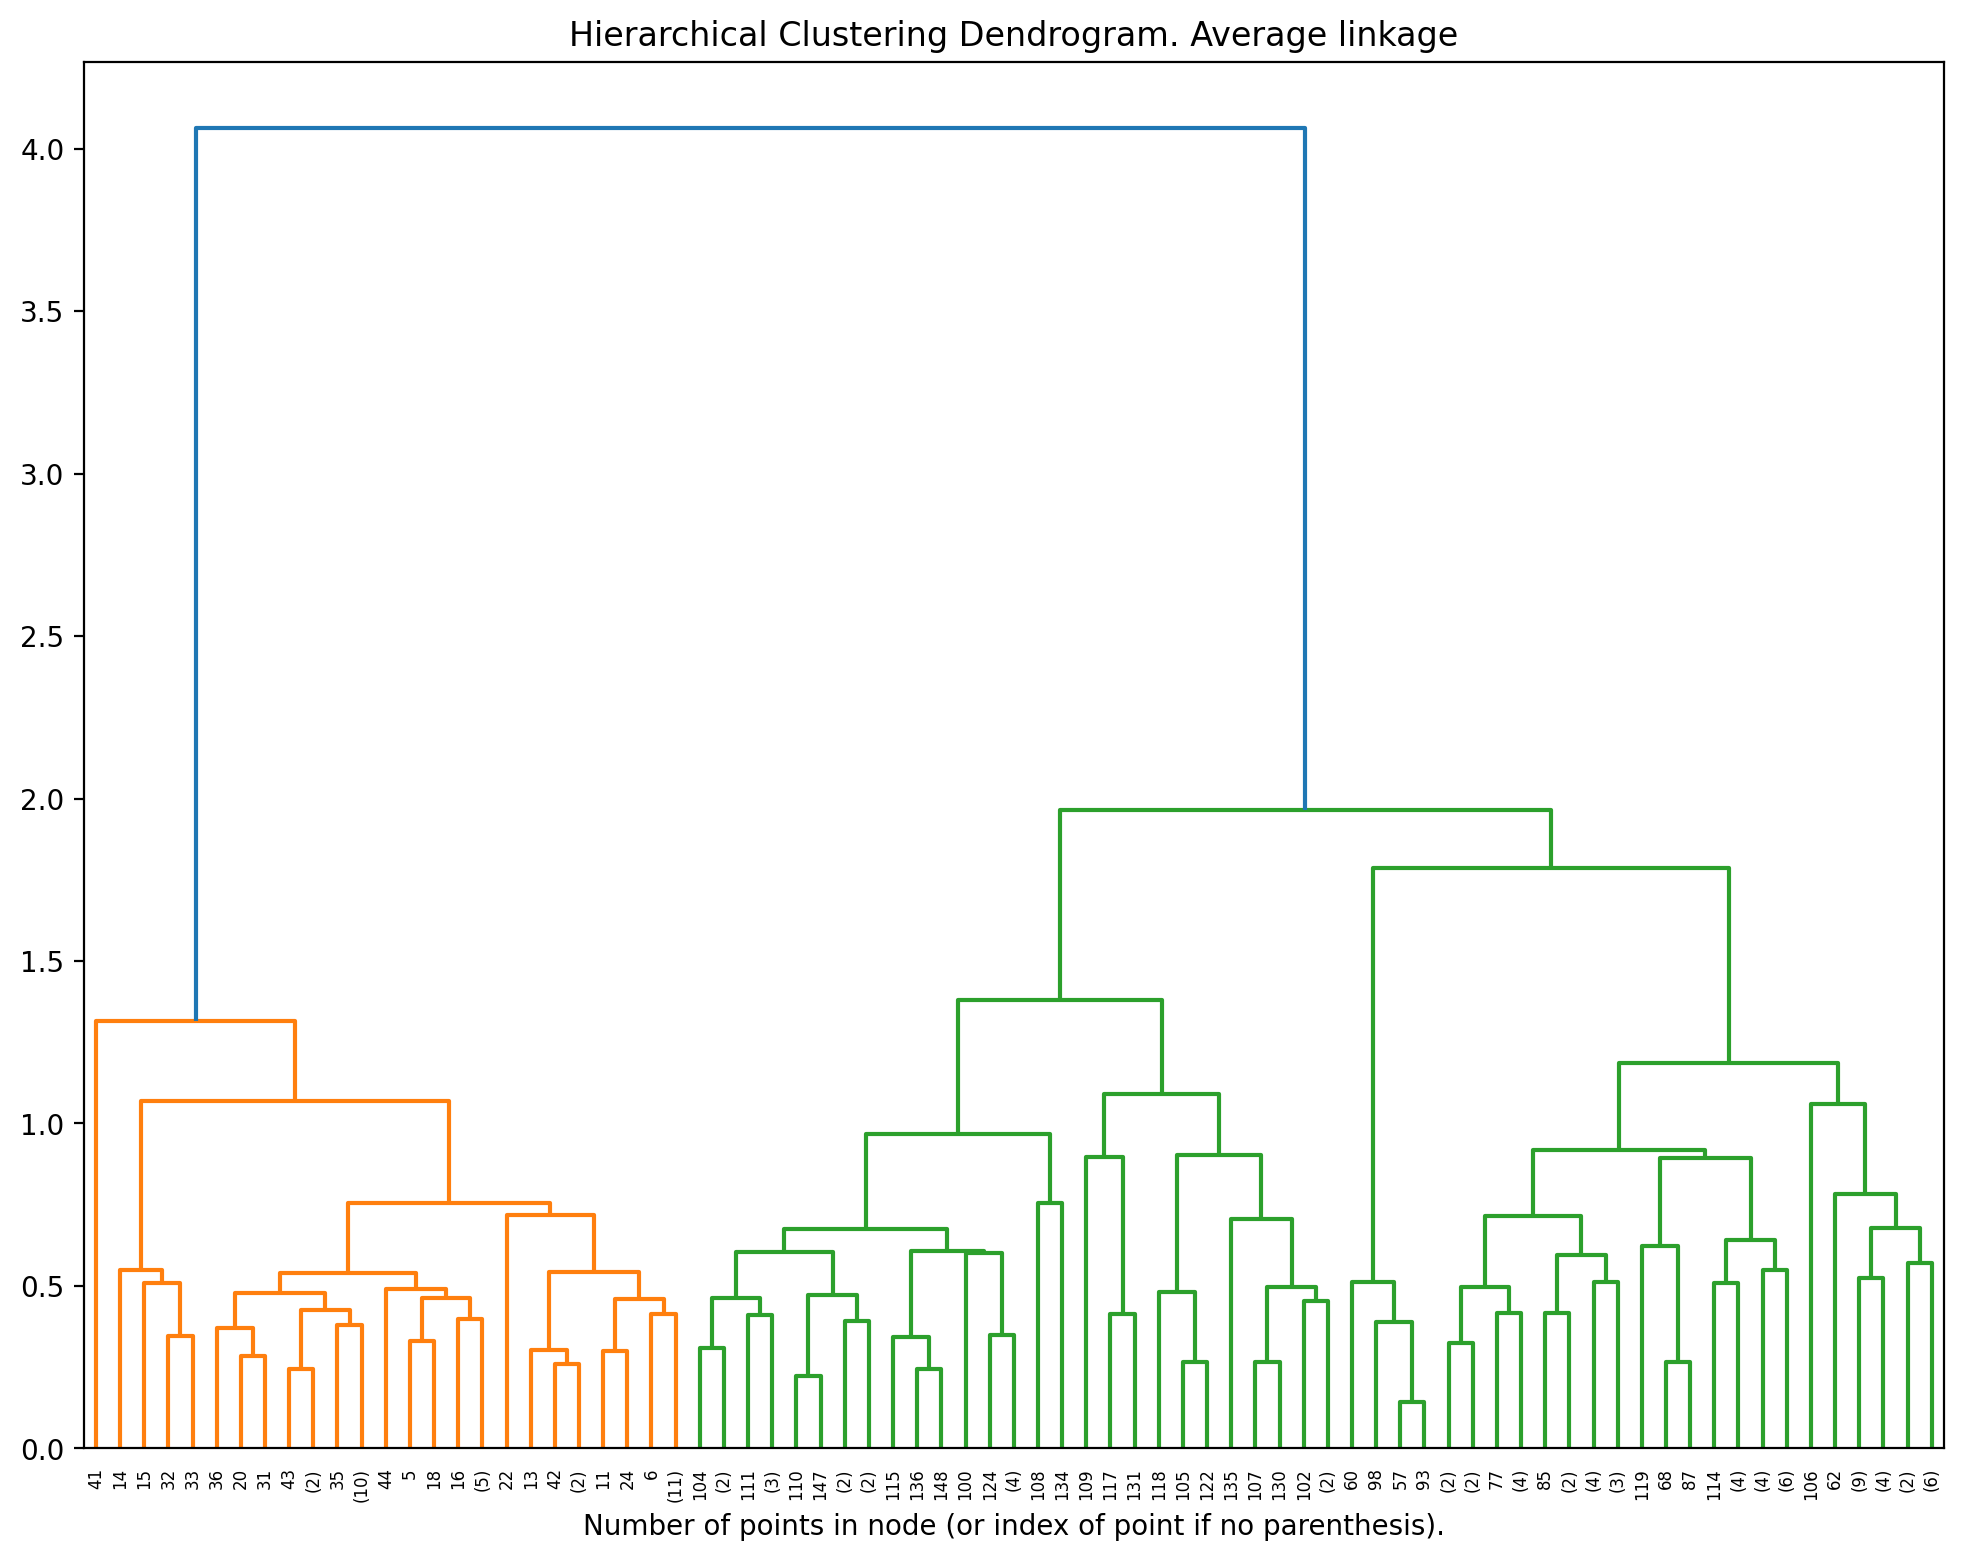

In [23]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram. Average linkage')
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

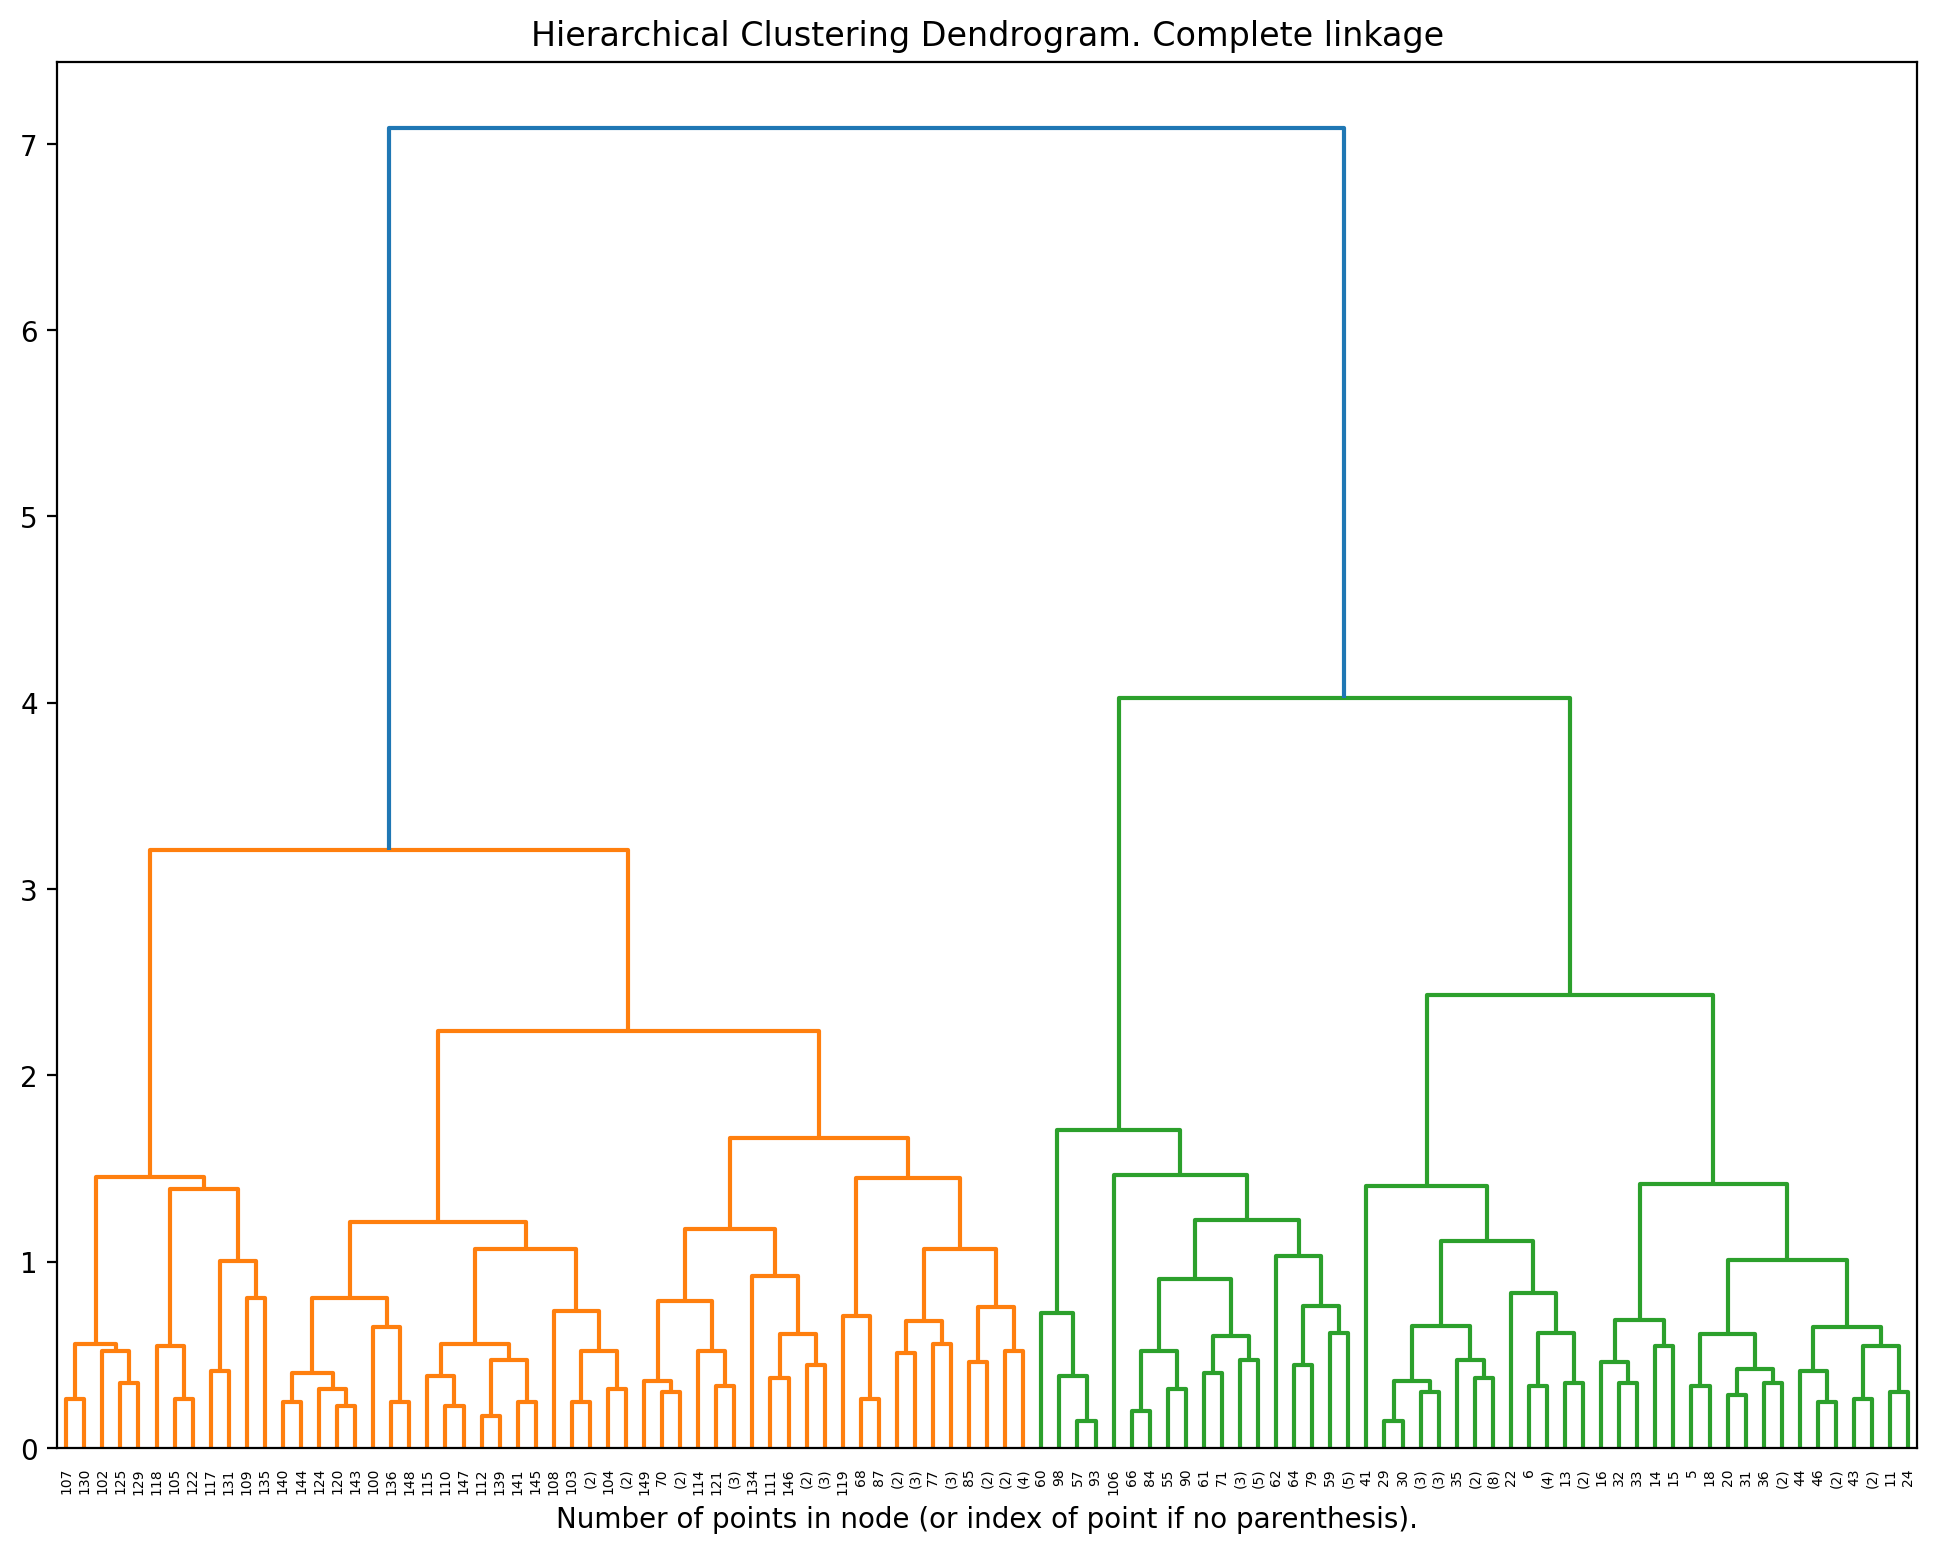

In [24]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram. Complete linkage')
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

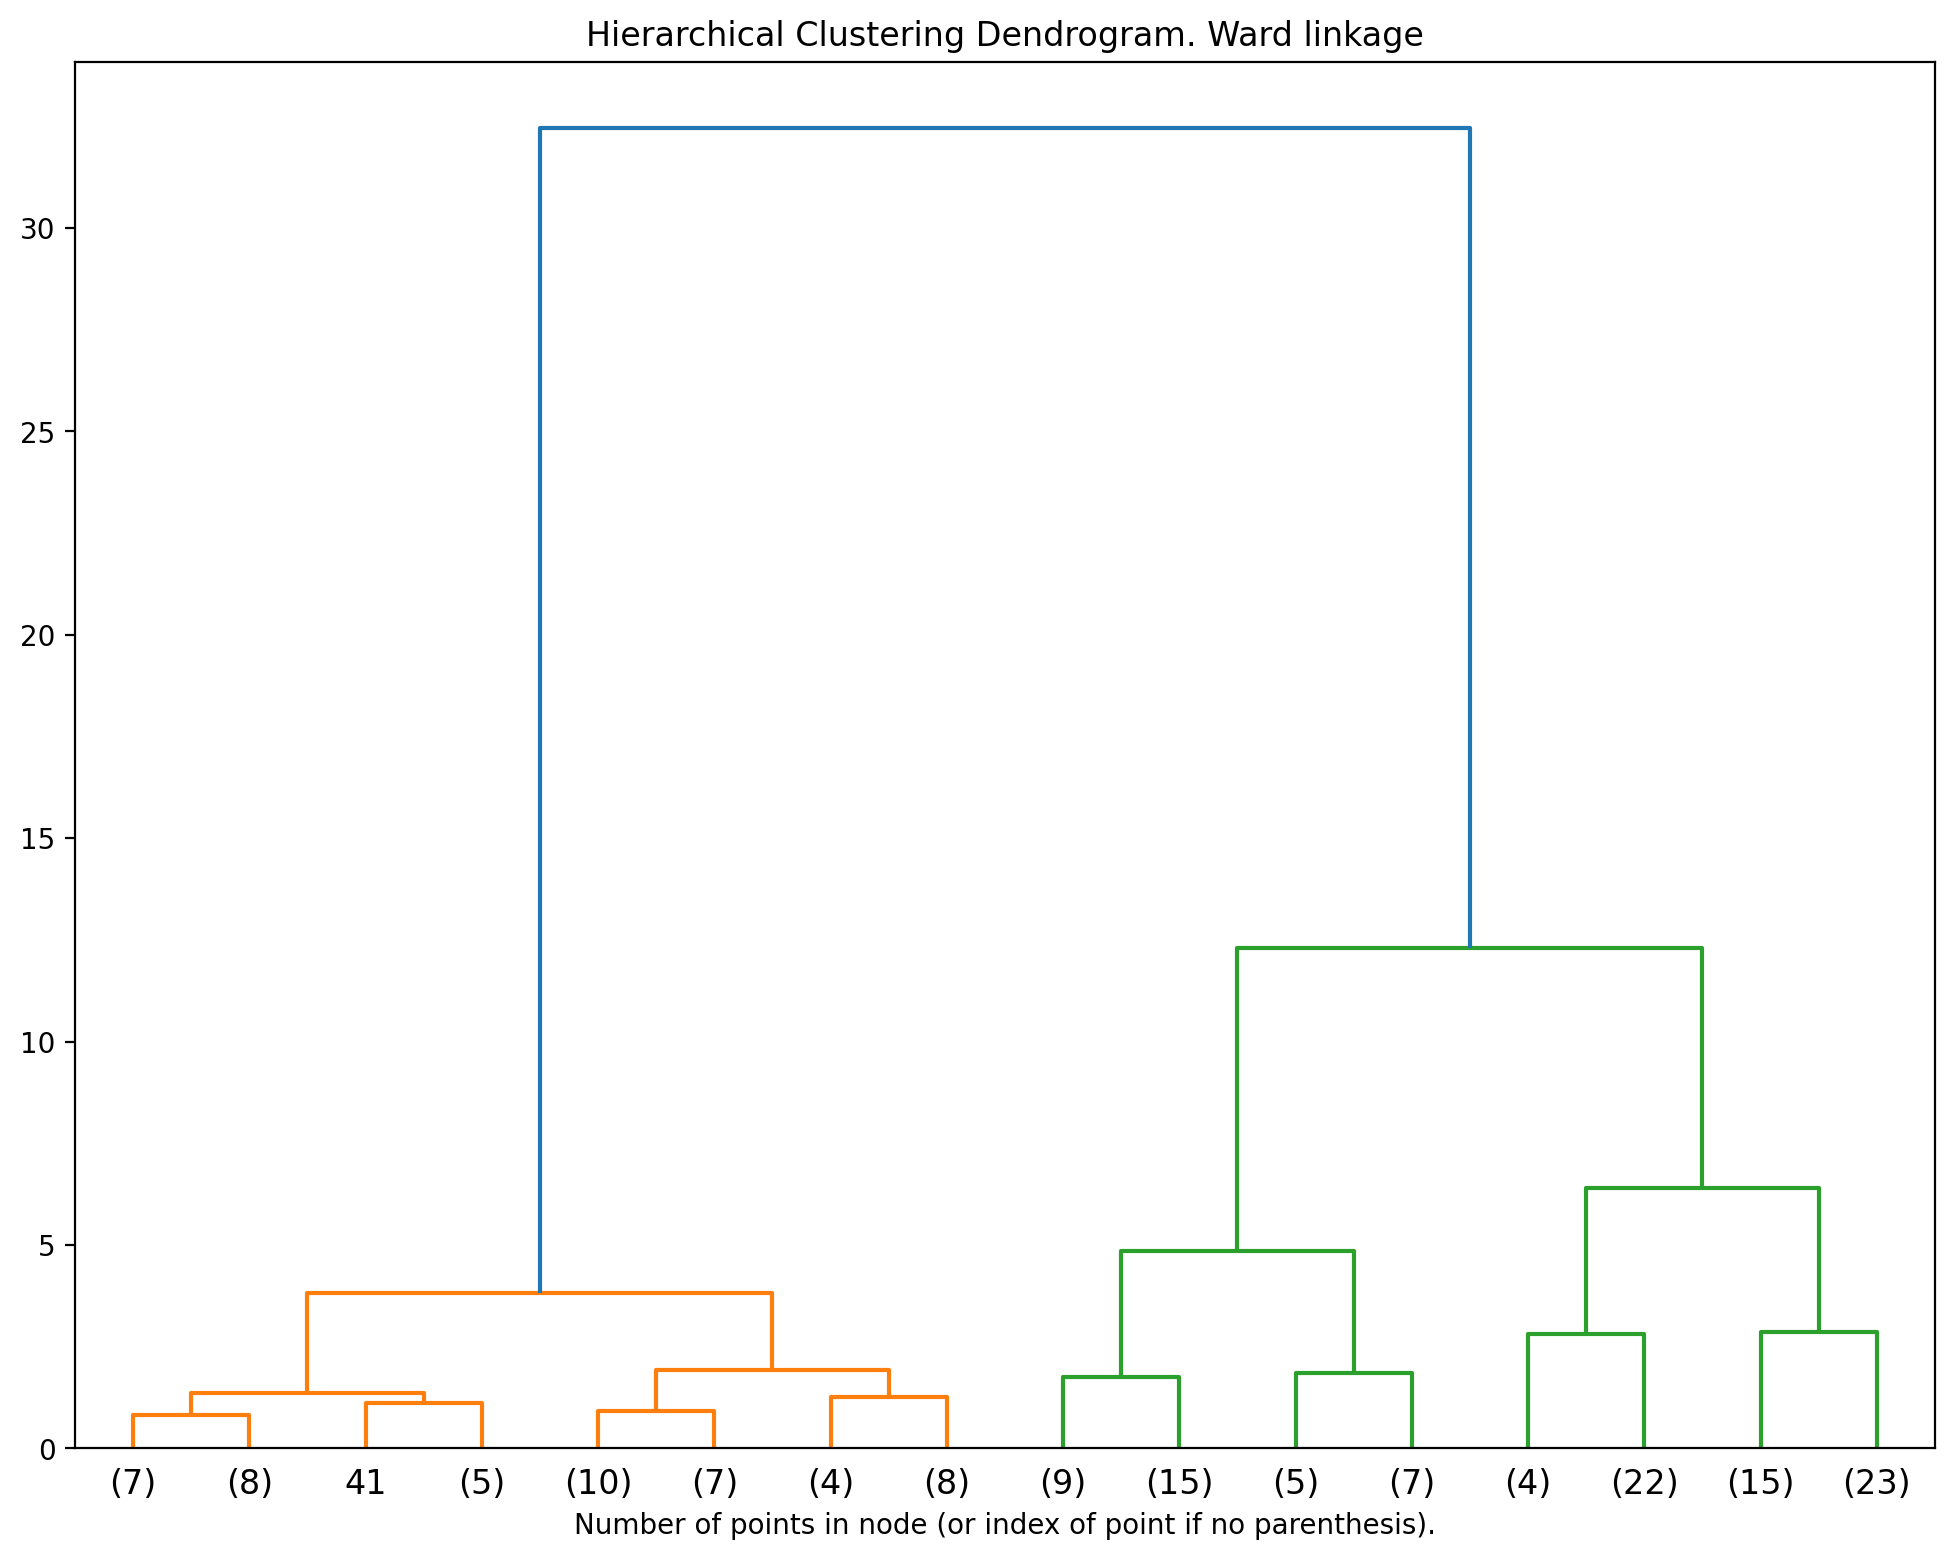

In [25]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram. Ward linkage')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [26]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist # Pairwise distances between observations in n-dimensional space.

x = np.zeros((150,2))
np.random.seed(seed=42)
x[:50, 0]     = np.random.normal(loc=0.0, scale=0.3, size=50) # x coordinate of the points
x[:50, 1]     = np.random.normal(loc=0.0, scale=0.3, size=50) # y coordinate of the points
x[50:100, 0]  = np.random.normal(loc=2.0, scale=0.5, size=50)
x[50:100, 1]  = np.random.normal(loc=-1.0, scale=0.2, size=50)
x[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
x[100:150, 1] = np.random.normal(loc=2.0, scale=0.5, size=50)

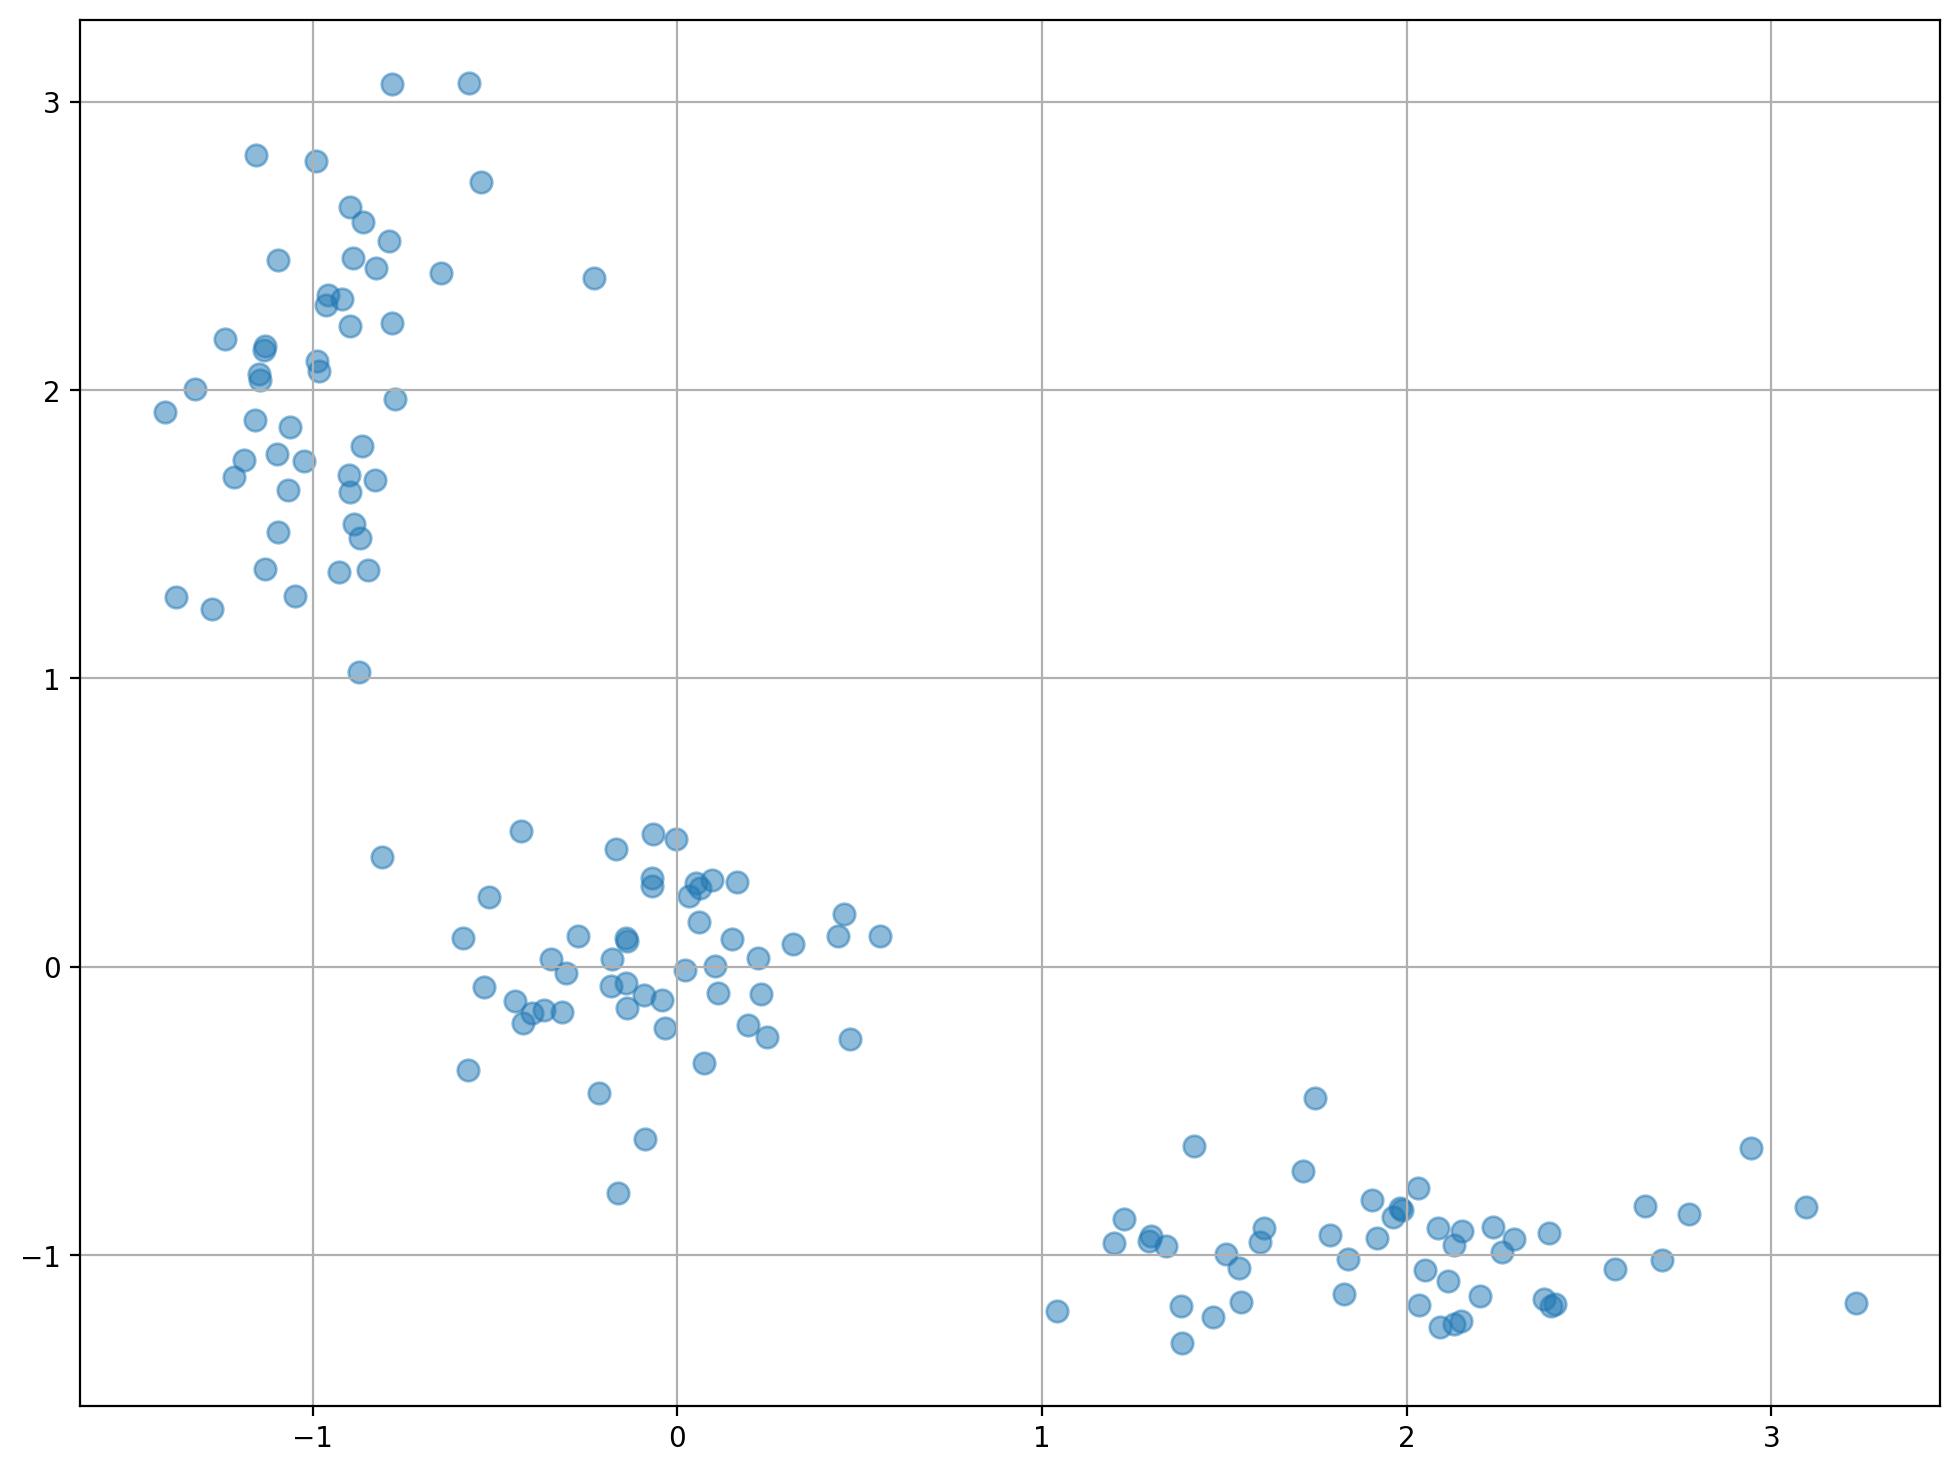

In [27]:
plt.scatter(x[:,0],x[:,1], s=60, alpha=0.5)
plt.grid()

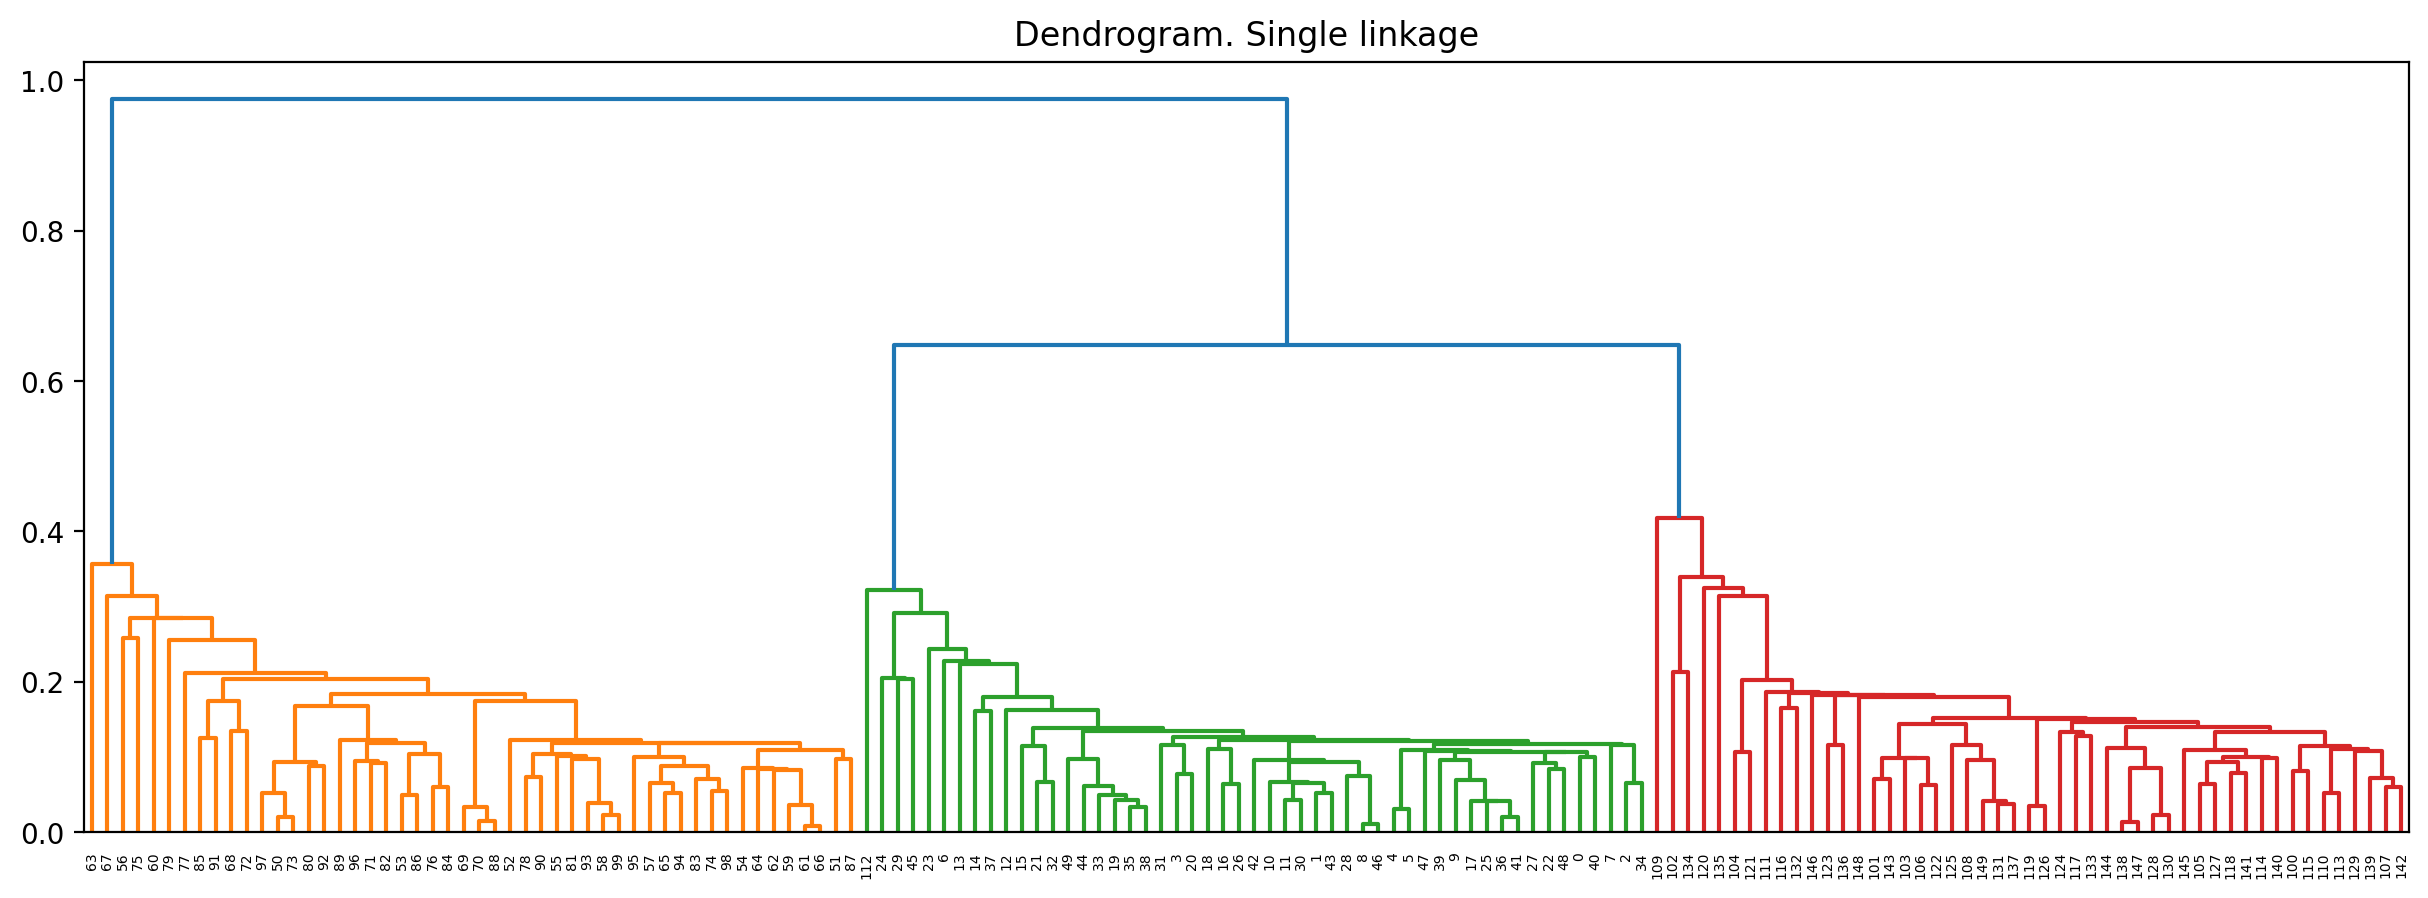

In [37]:
# The distance metric to use. The distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 
# 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis',
# 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'.
distance_mat = pdist(x, metric='euclidean')

Z= hierarchy.linkage(distance_mat, method='single')

plt.figure(figsize=(15,5))
dn = hierarchy.dendrogram(Z,color_threshold=0.5)
plt.title('Dendrogram. Single linkage')
plt.show()

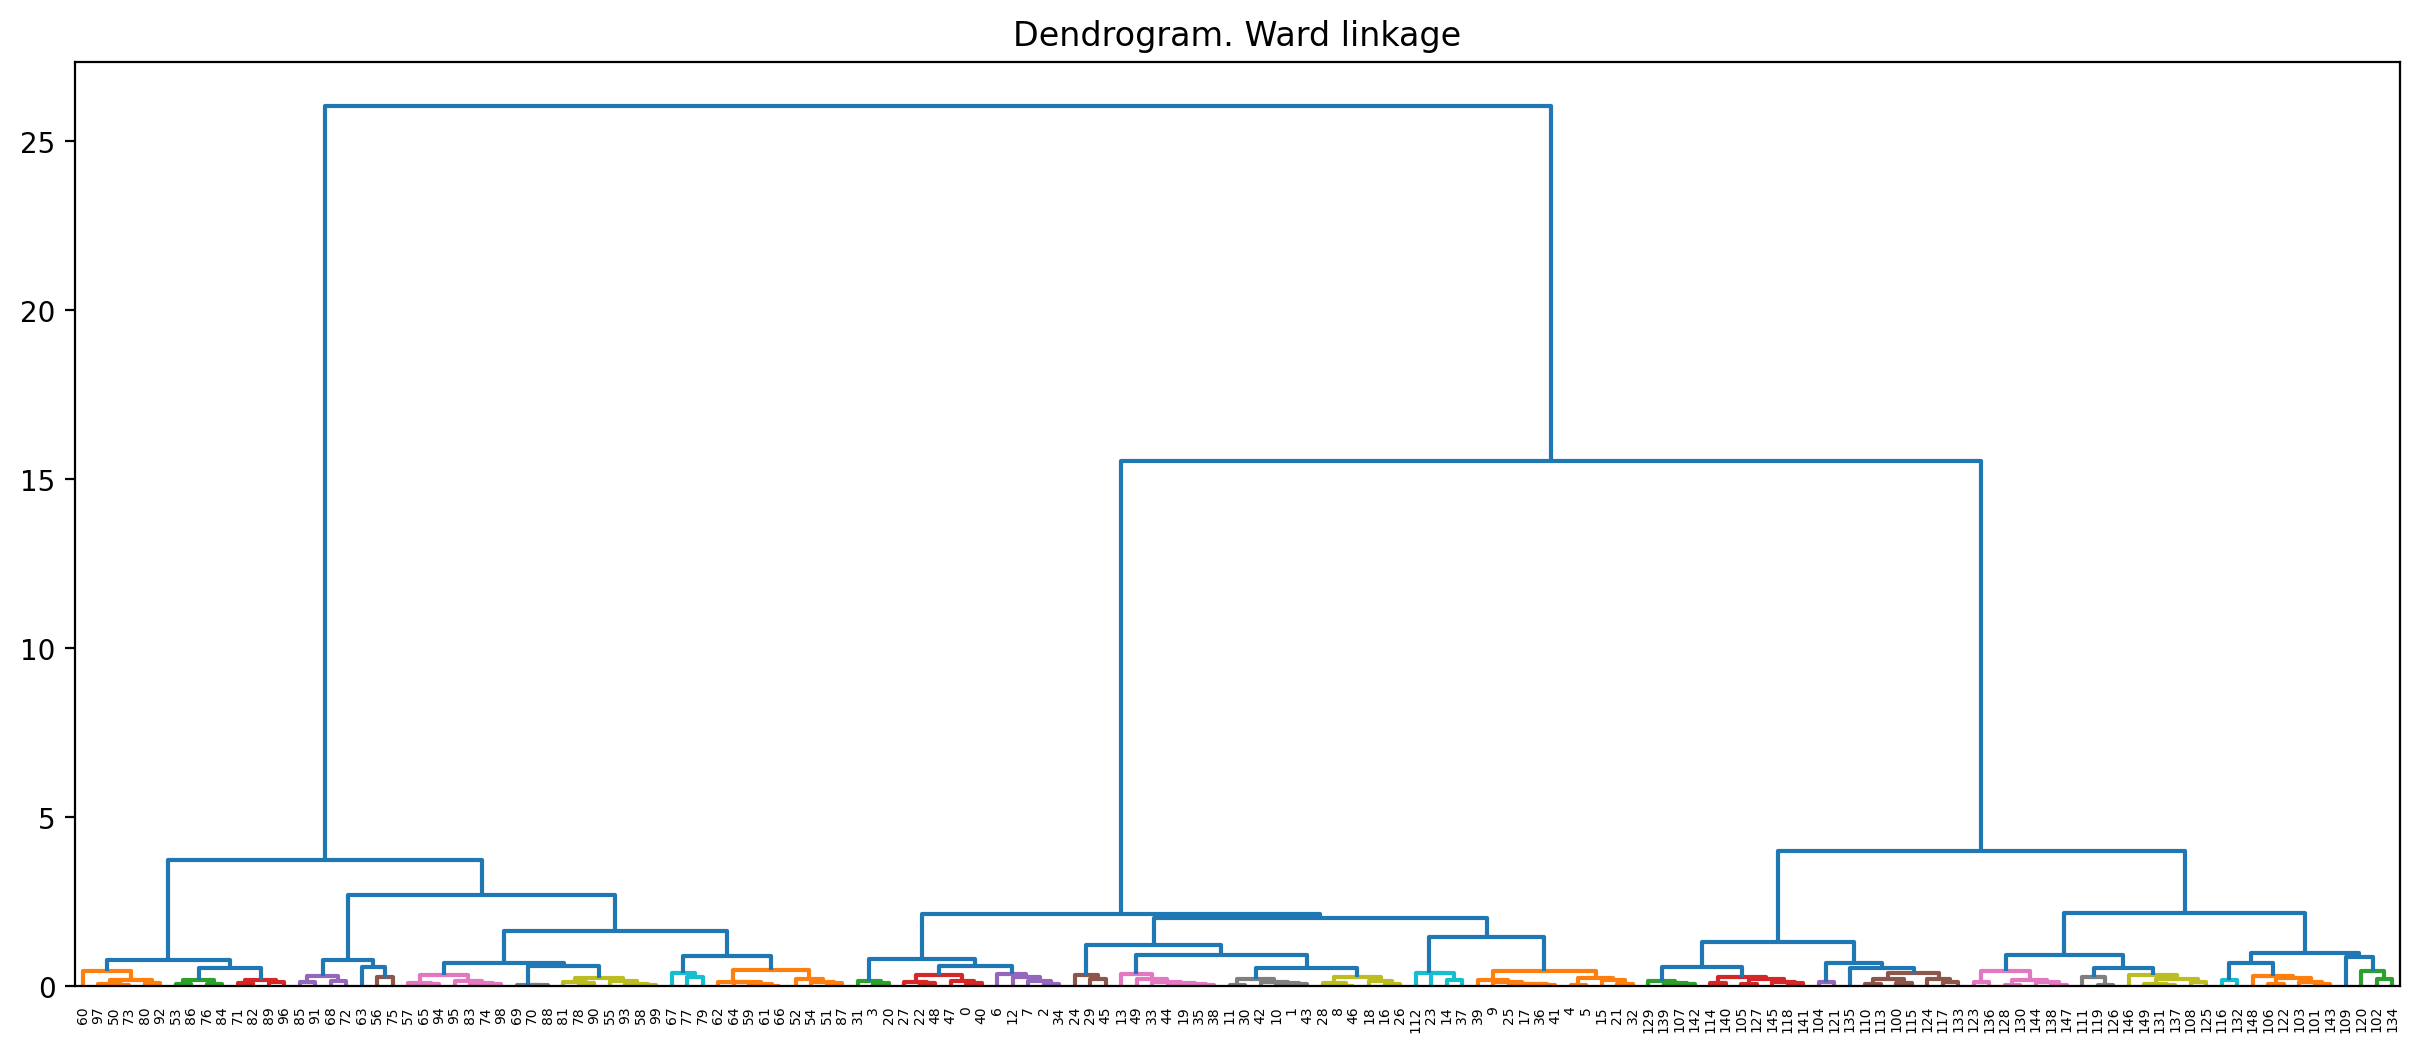

In [38]:
Z= hierarchy.linkage(distance_mat, 'ward')
plt.figure(figsize=(15,6))
dn = hierarchy.dendrogram(Z,color_threshold=.5, p=3)
plt.title('Dendrogram. Ward linkage')
plt.show()
# The vertical height of the dendogram shows the distance between points.

## DBSCAN

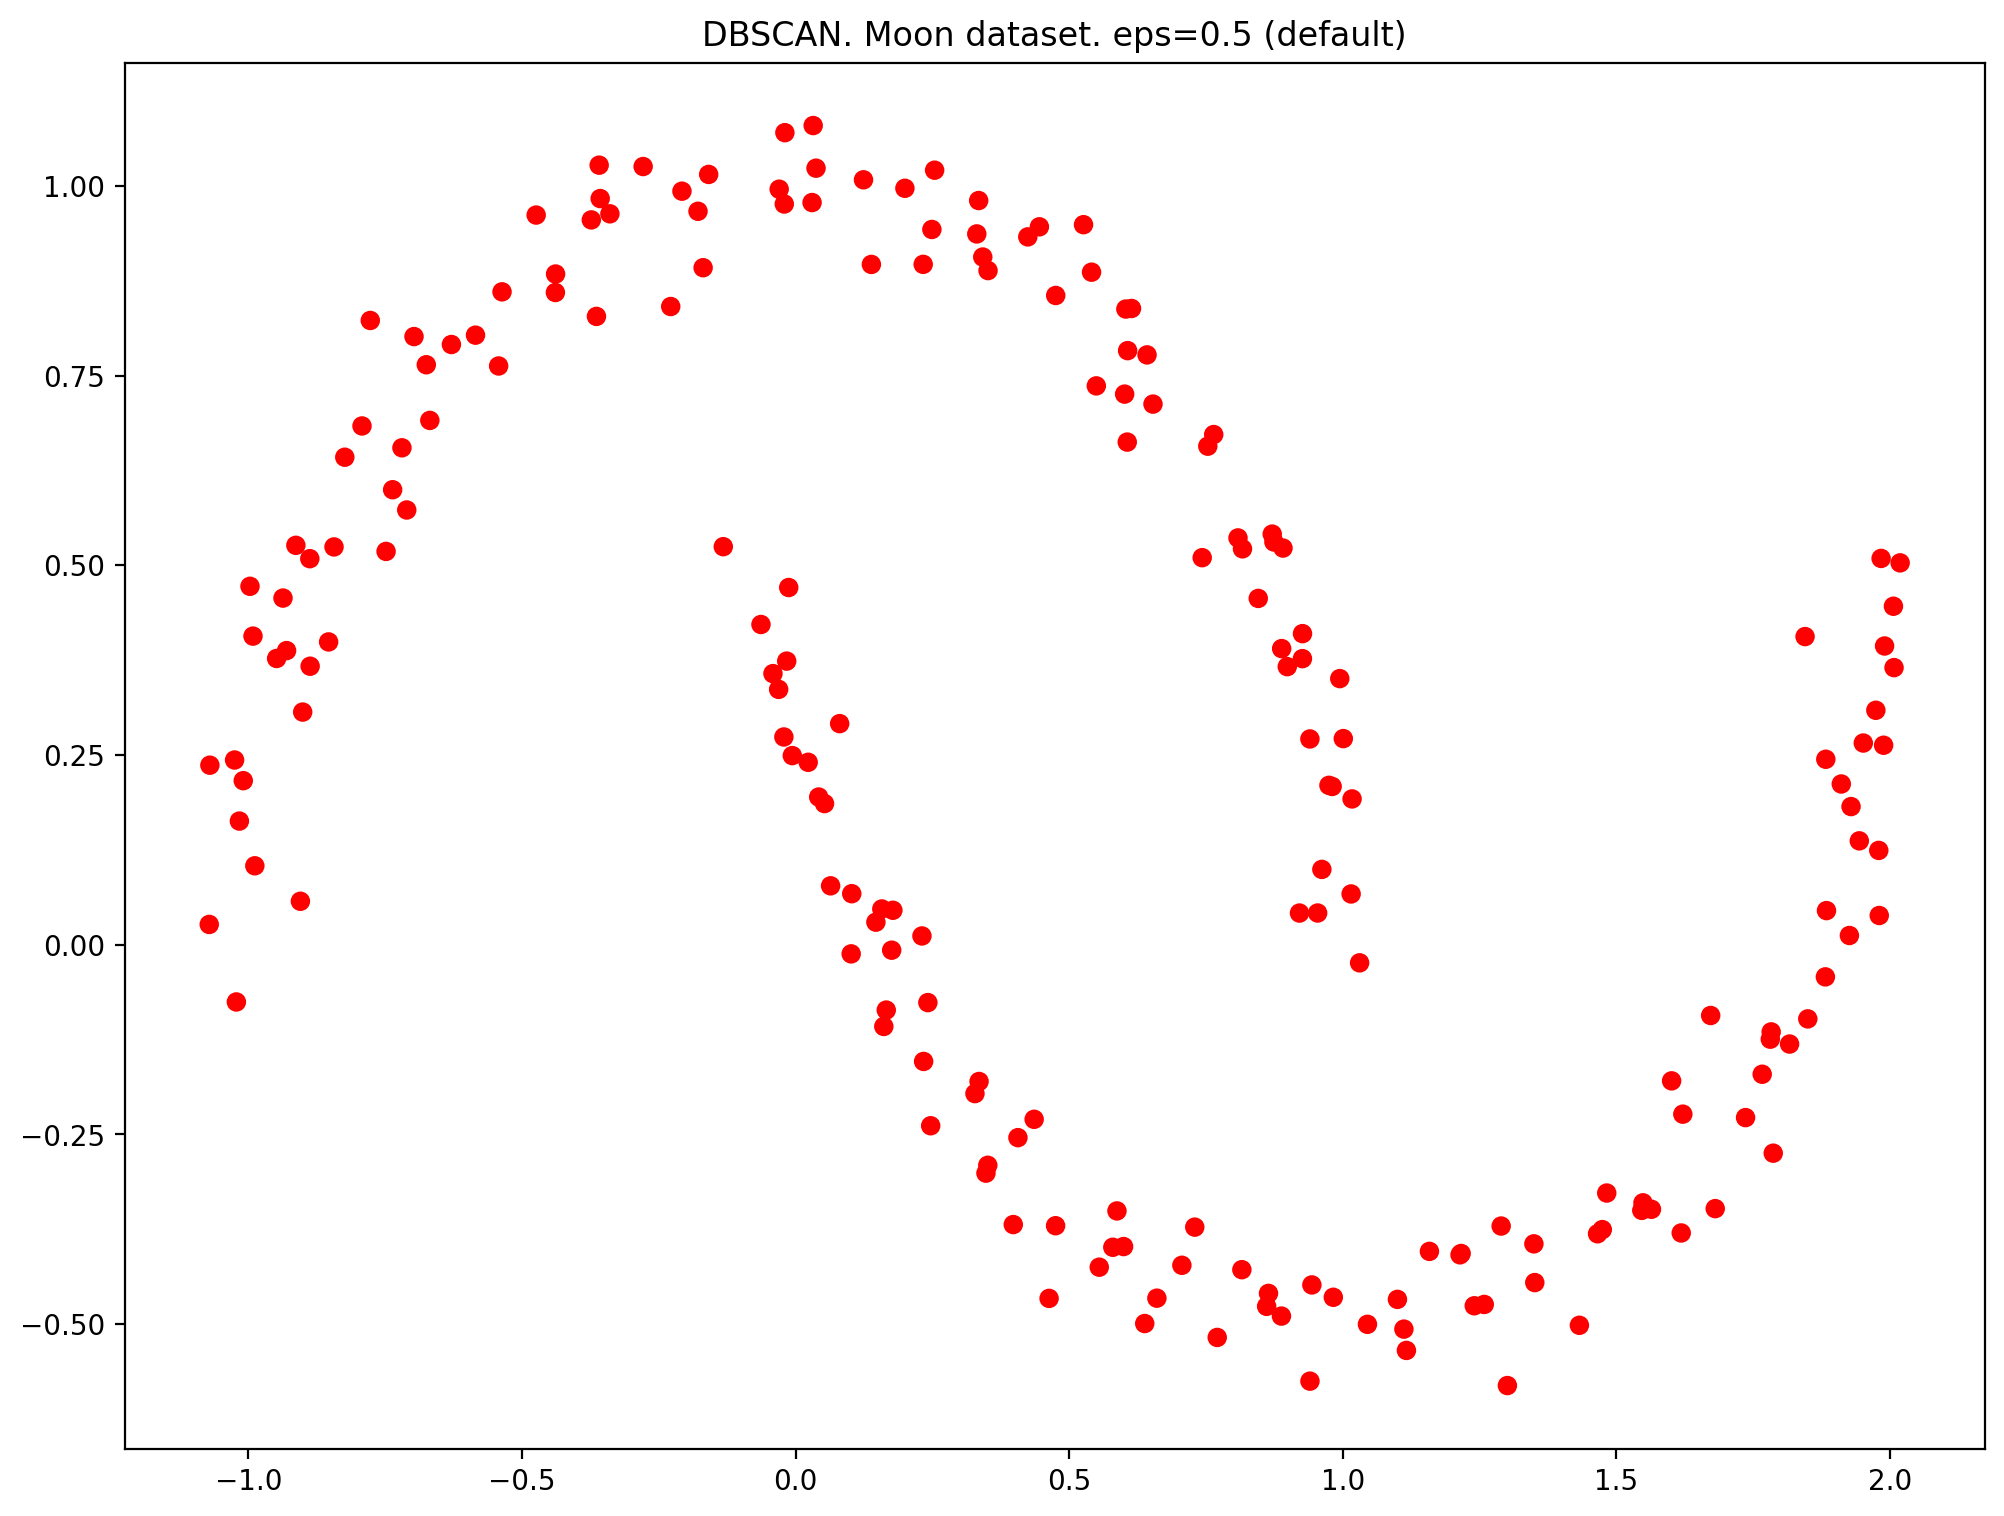

In [39]:
scan_moons = DBSCAN() # если запустить метод без указания eps то все точки в один кластер
y_moons = scan_moons.fit_predict(X_moon)
plt.figure(figsize=(12,9))
plt.scatter(X_moon[:,0], X_moon[:,1], c=y_moons, cmap='autumn')
plt.title('DBSCAN. Moon dataset. eps=0.5 (default)')
plt.show()

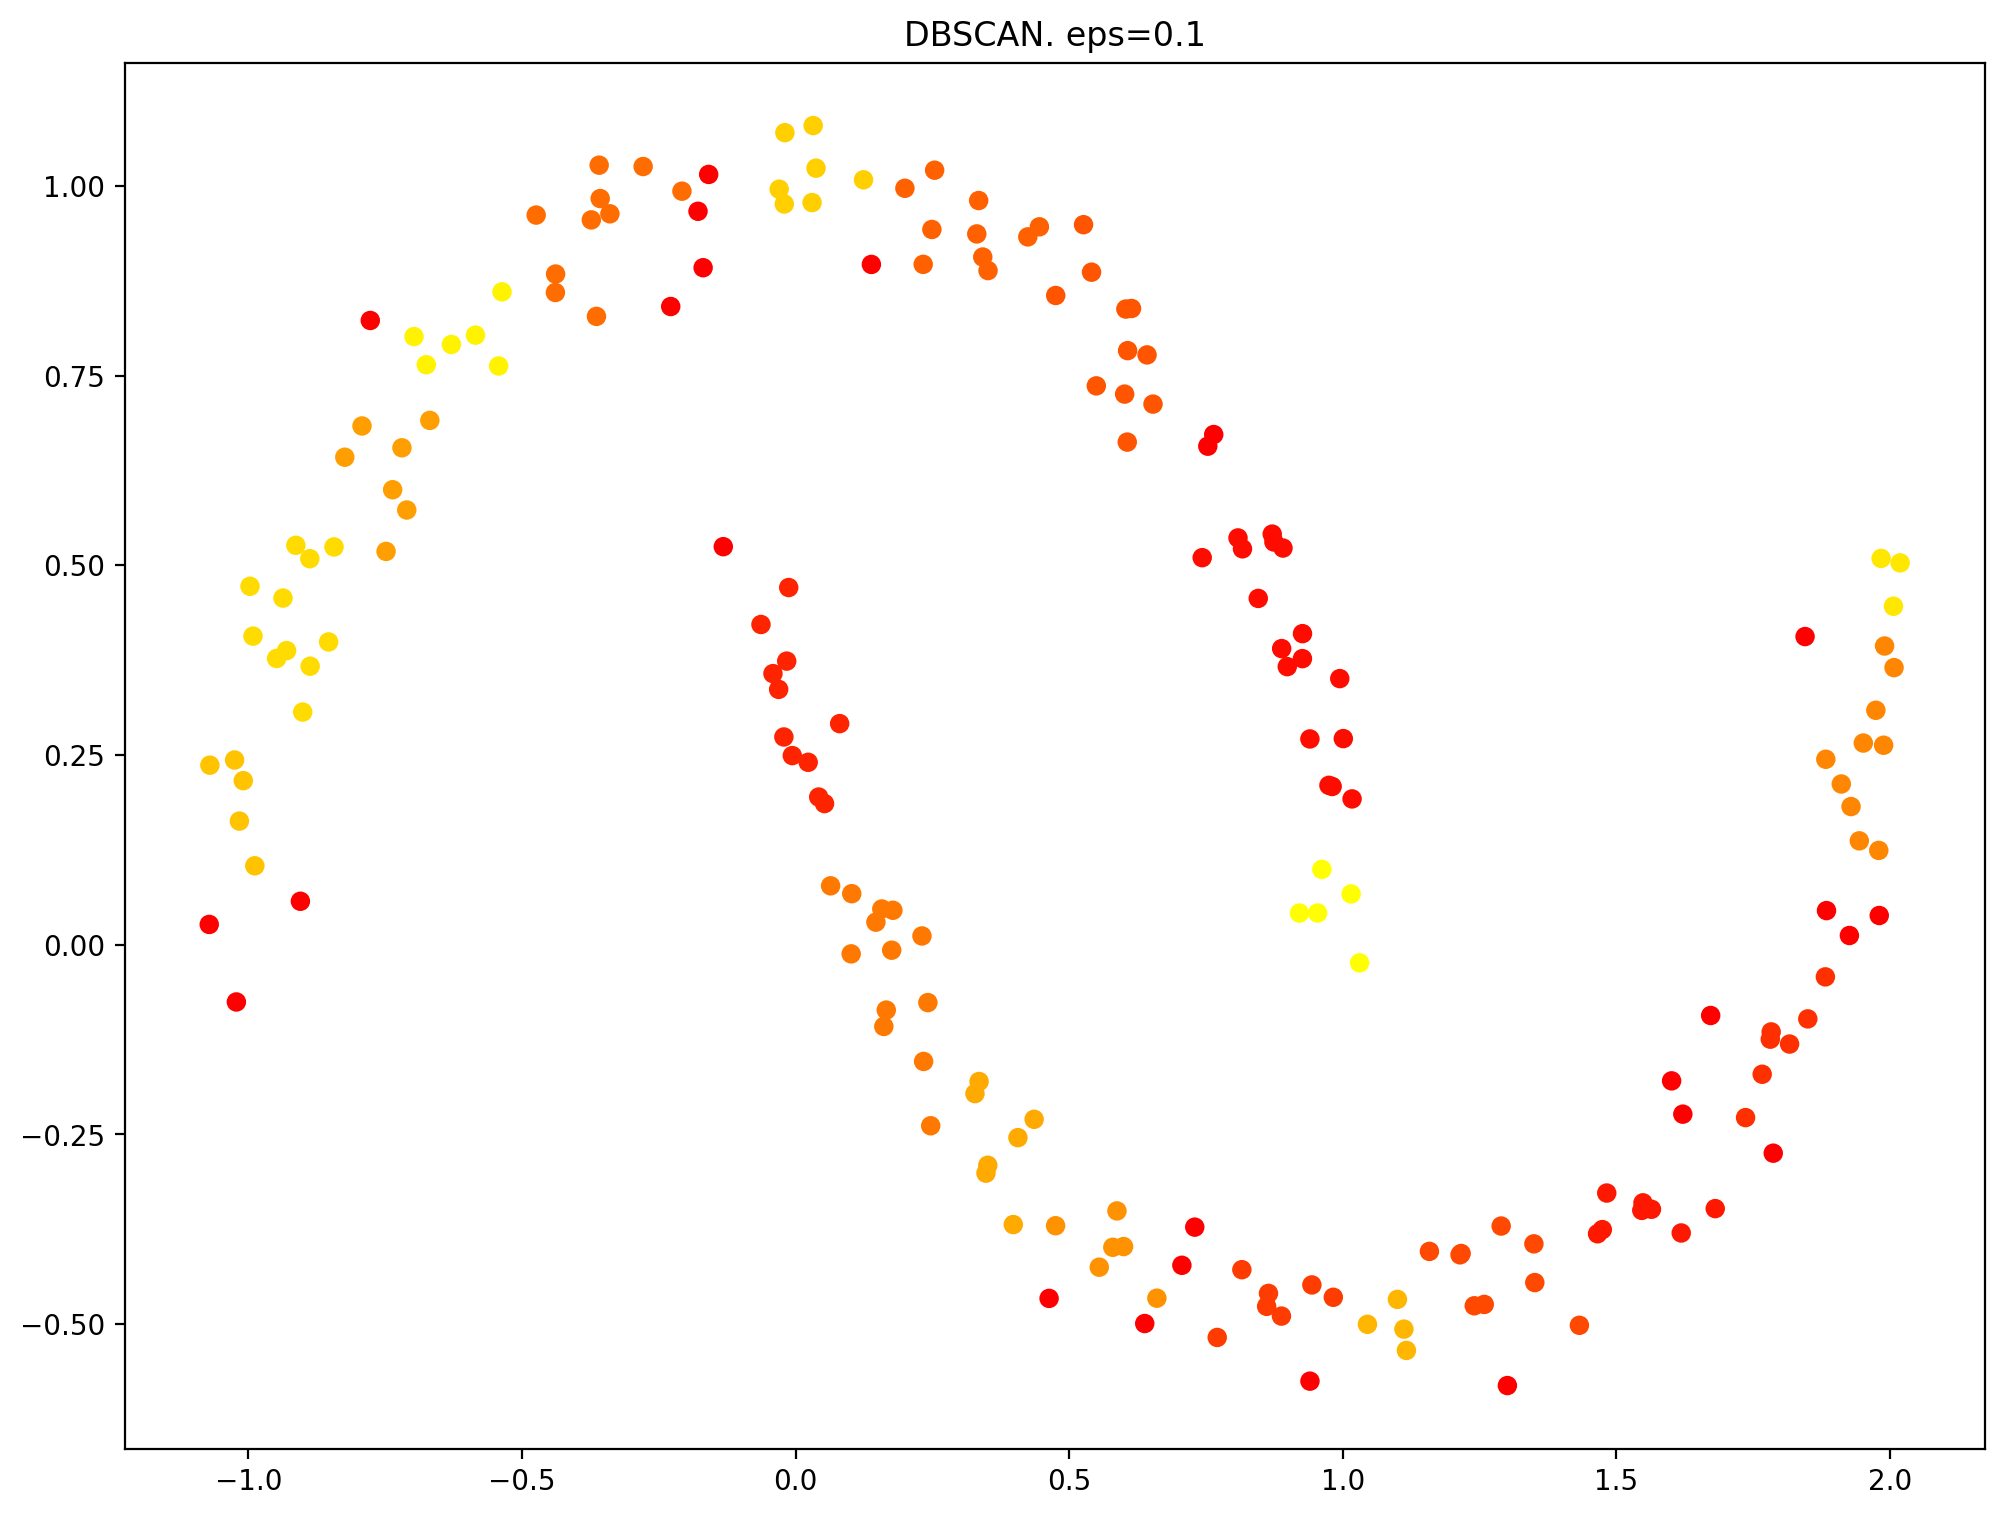

In [40]:
# eps -   The maximum distance between two samples for one to be considered as in the neighborhood of the other.
#  This is not a maximum bound on the distances of points within a cluster. 
# This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

scan_moons = DBSCAN(eps=0.1)
y_moons = scan_moons.fit_predict(X_moon)
plt.figure(figsize=(12,9))
plt.scatter(X_moon[:,0], X_moon[:,1], c=y_moons, cmap='autumn')
plt.title('DBSCAN. eps=0.1')
plt.show()

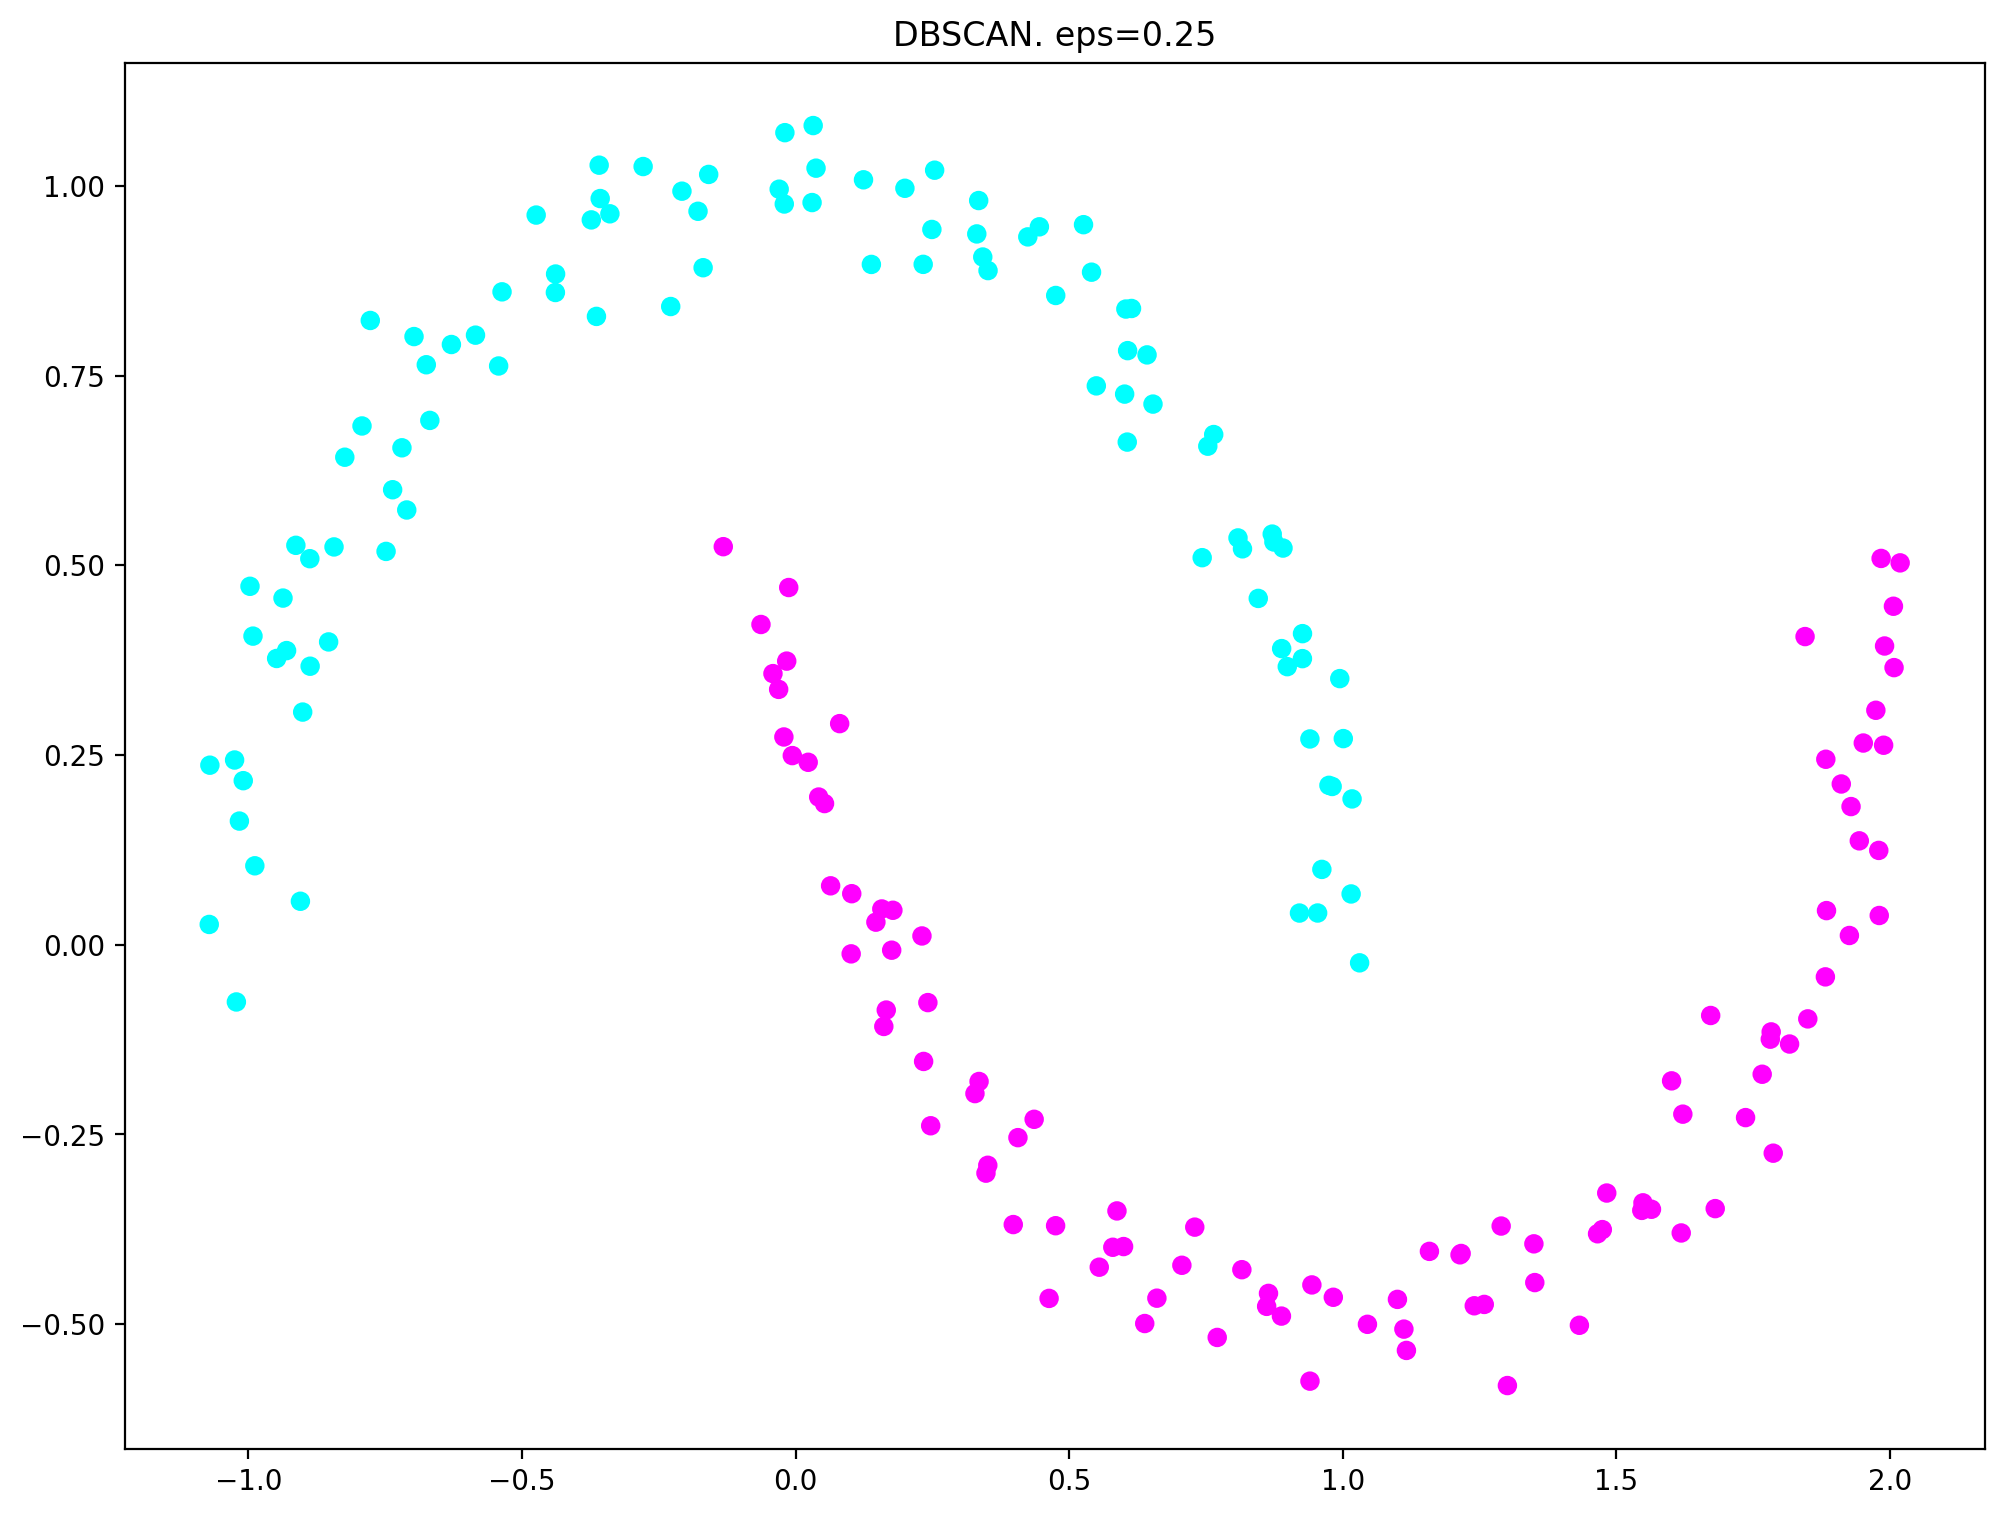

In [32]:
scan_moons = DBSCAN(eps=0.25) # путем подбора правильного eps приходим к верному кол-ву кластеров
y_moons = scan_moons.fit_predict(X_moon)
plt.figure(figsize=(12,9))
plt.scatter(X_moon[:,0], X_moon[:,1], c=y_moons, cmap='cool')
plt.title('DBSCAN. eps=0.25')
plt.show()

In [33]:
# !python -m pip install hdbscan -q

In [34]:
# !python -m pip install --upgrade pip -q

In [35]:
import hdbscan

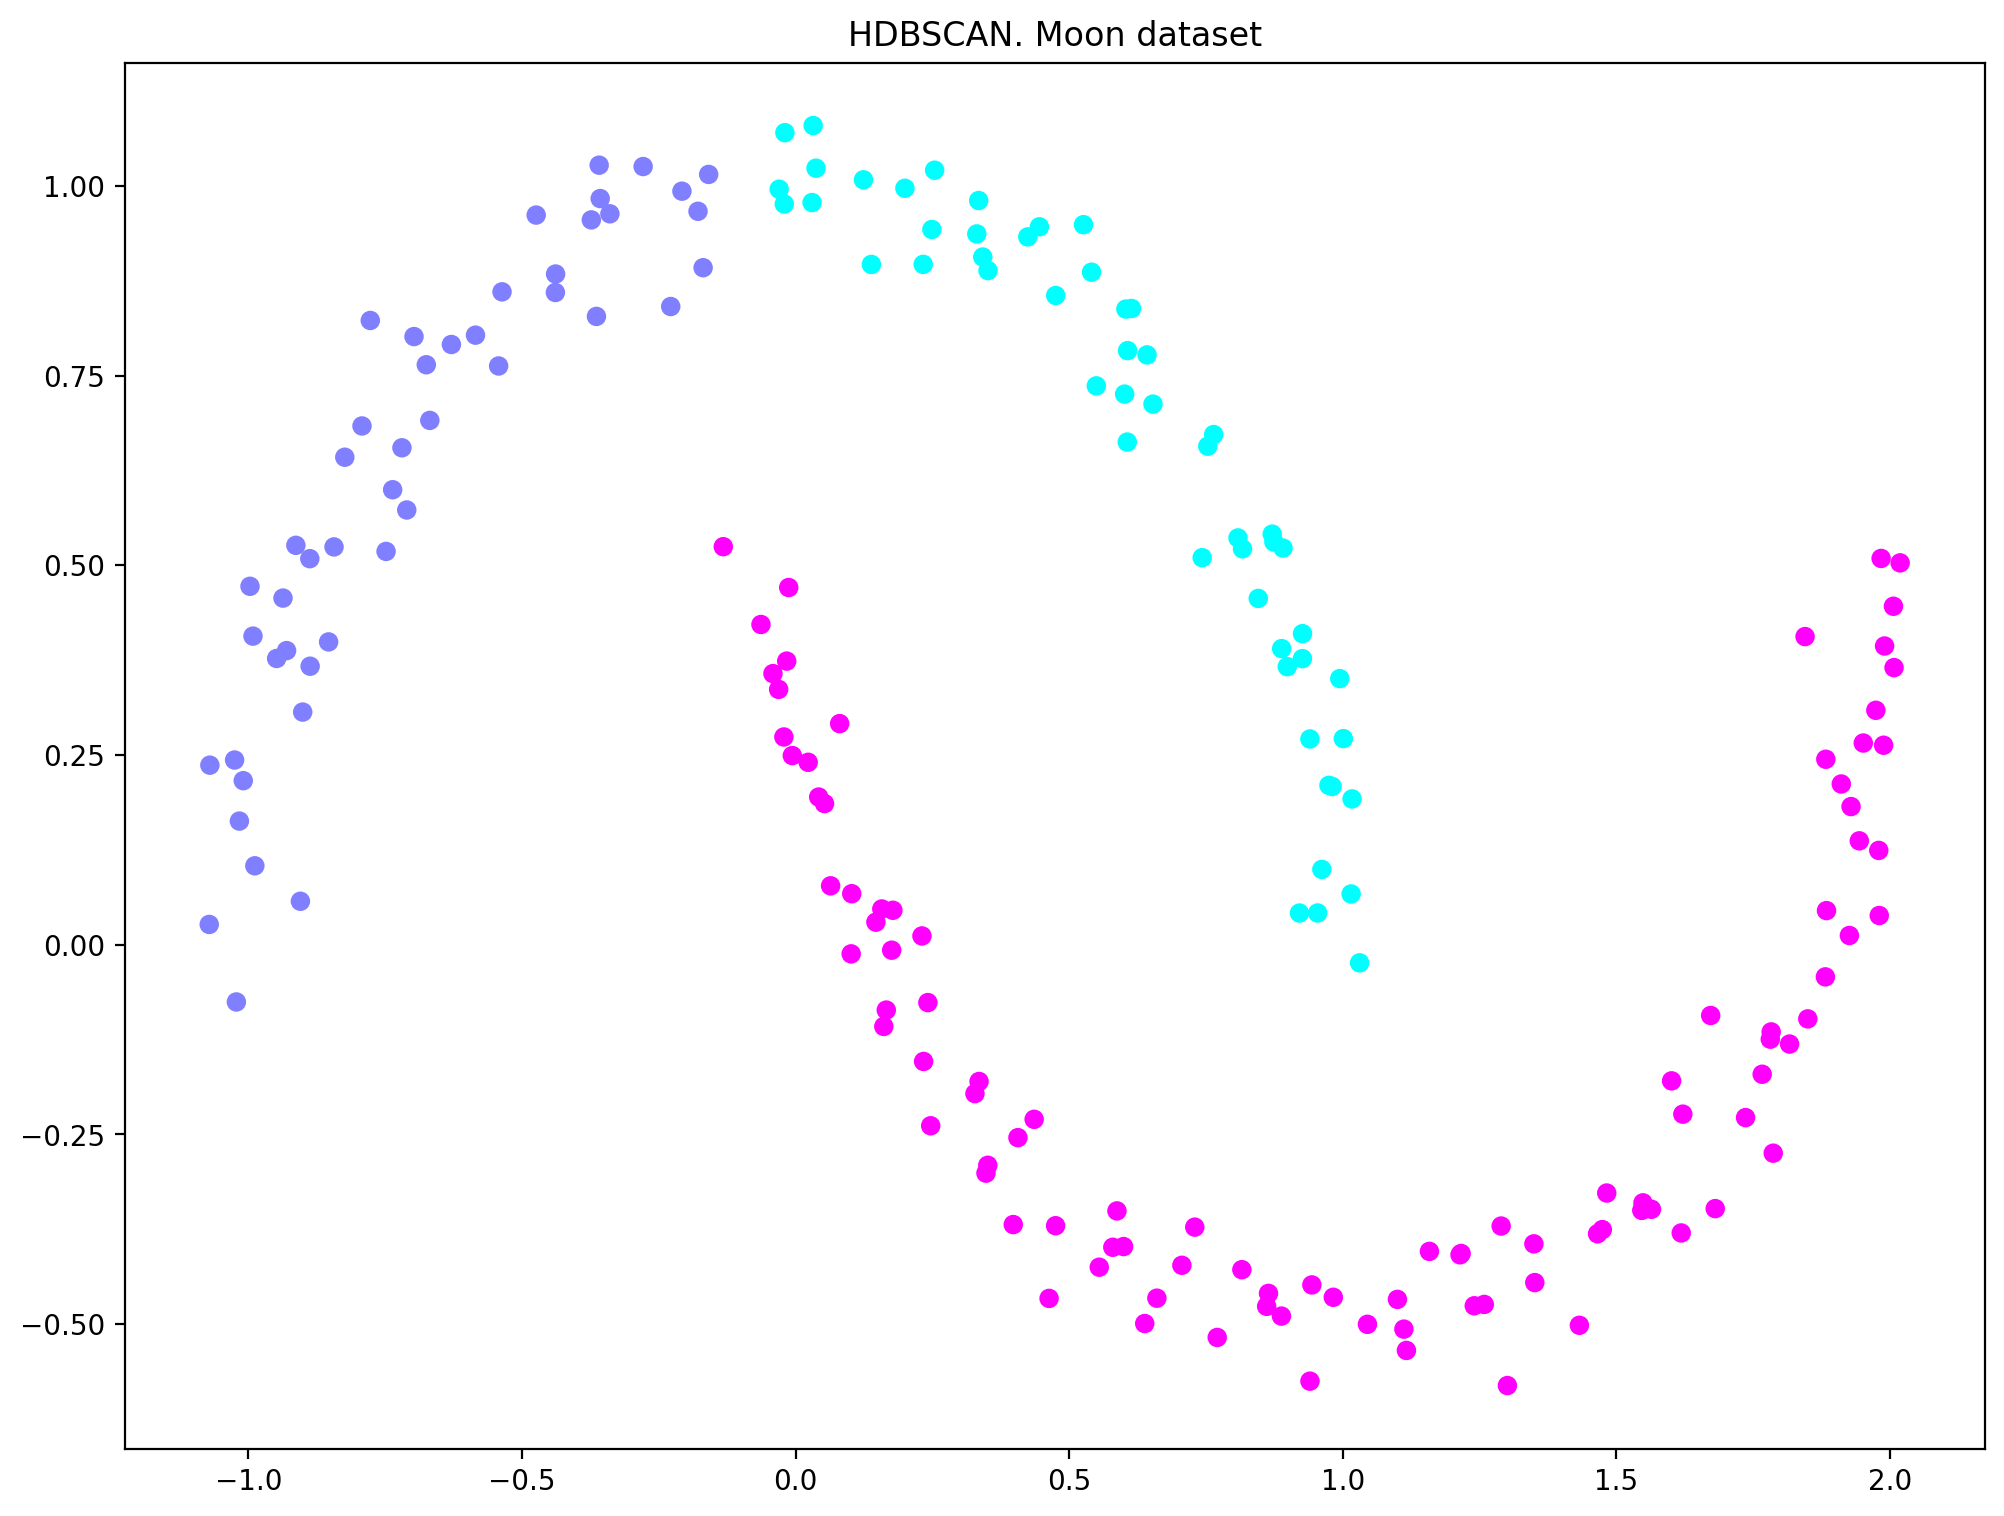

In [41]:
clusterer = hdbscan.HDBSCAN() # HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications with Noise.
clusterer.fit(X_moon)
plt.figure(figsize=(12,9))

    # clusterer.labels_ - array of labels, one for each point in the dataset indicating cluster membership
plt.scatter(x= X_moon[:,0], y= X_moon[:,1],  c=clusterer.labels_, cmap='cool')
plt.title('HDBSCAN. Moon dataset')
plt.show()

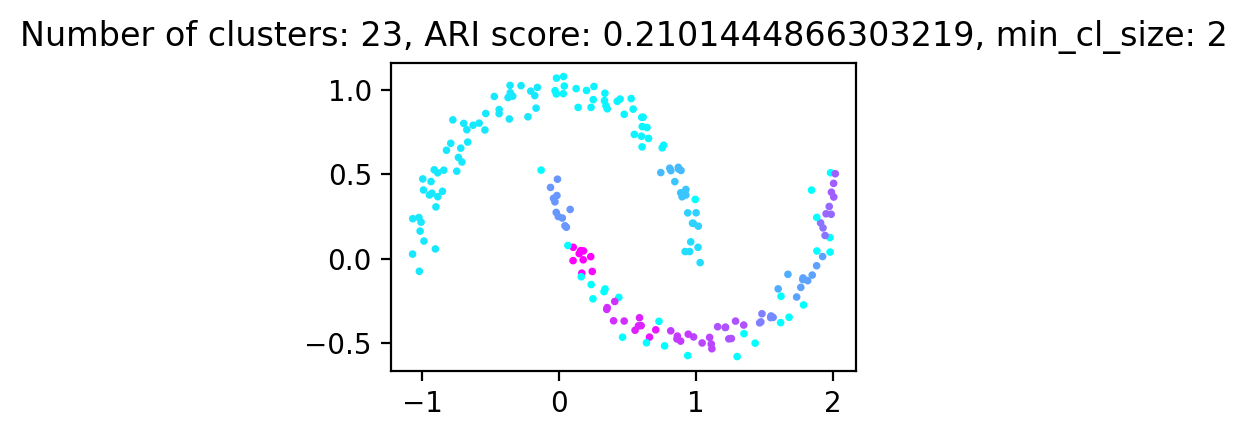

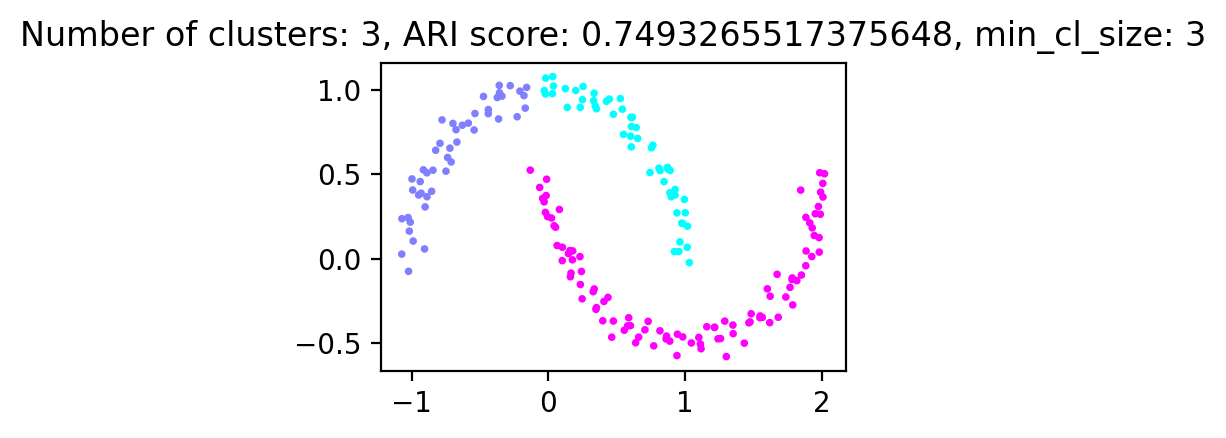

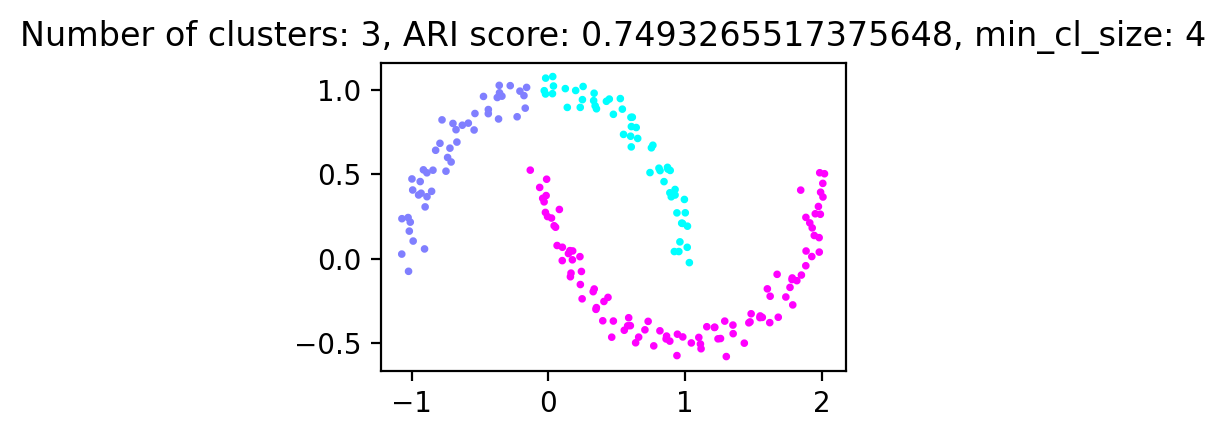

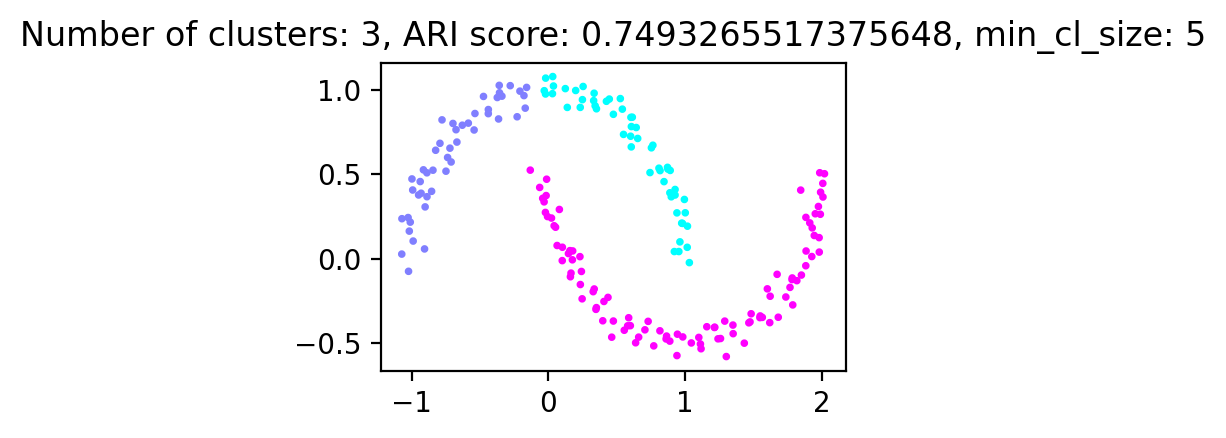

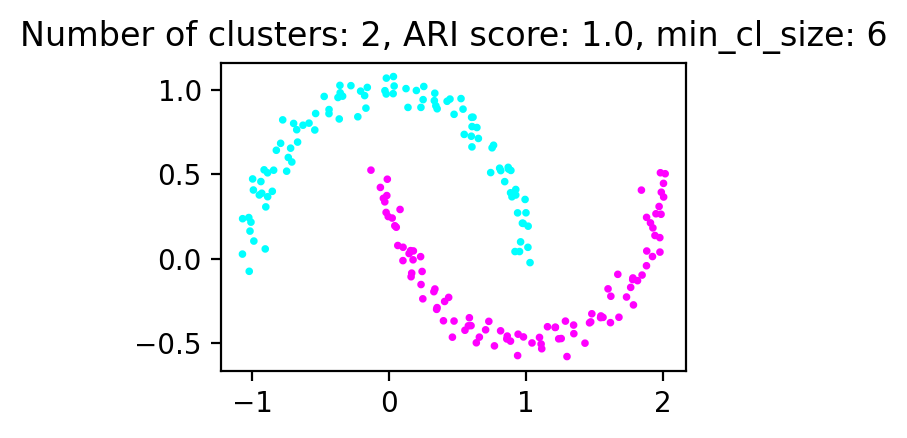

Number of clusters: 2, ARI score: 1.0, min_cl_size: 6


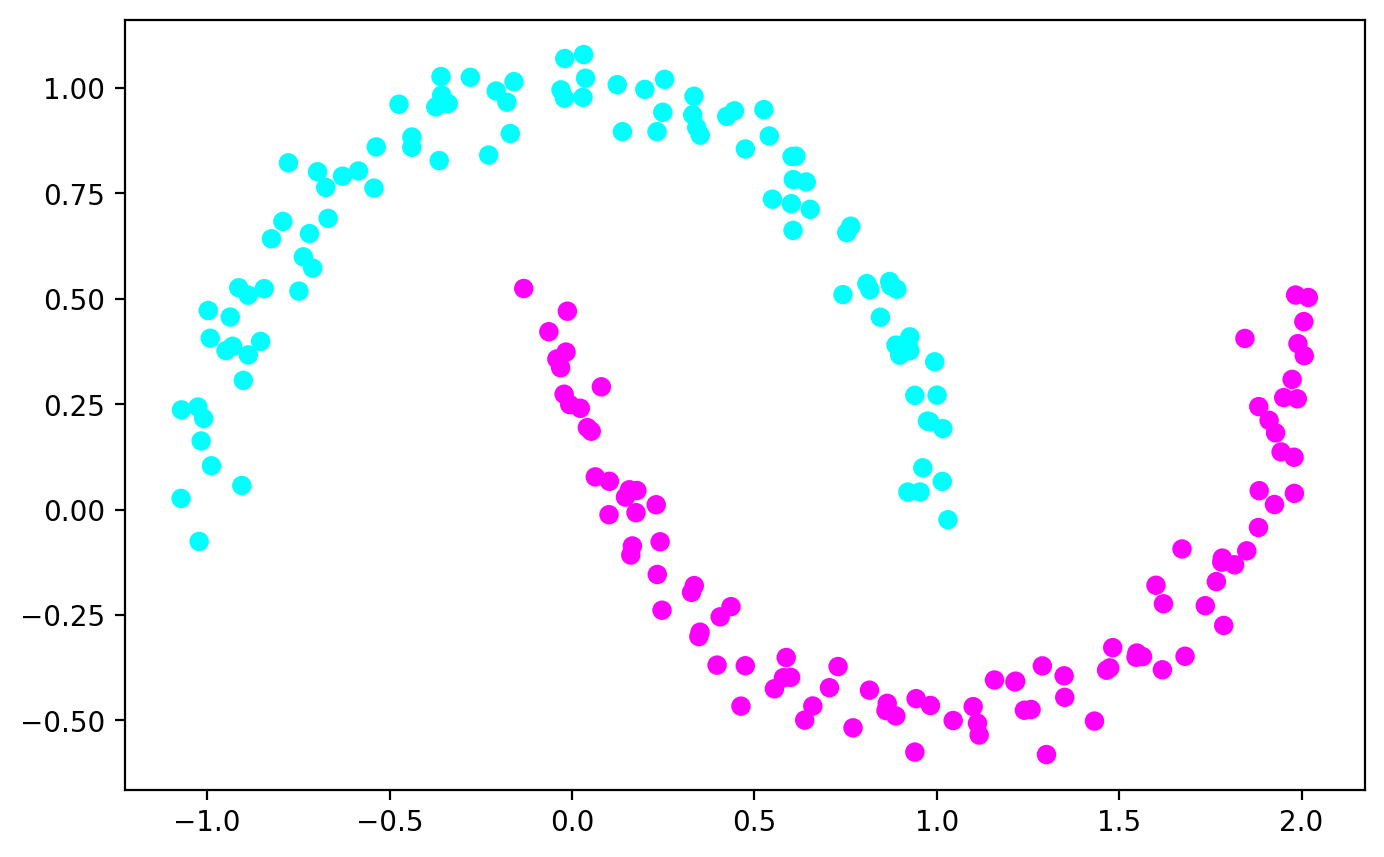

CPU times: user 2.06 s, sys: 591 ms, total: 2.65 s
Wall time: 1.35 s


In [42]:
%%time
ari_score = 0
min_cluster_size = 0
for cl_size in range(2, 31):
    if ari_score >= 0.99: # Best possible score, no need to continue
        break
    clusterer = hdbscan.HDBSCAN(min_cluster_size=cl_size)
    clusterer.fit(X_moon)
    ari_score_cur = adjusted_rand_score(y_moon, clusterer.labels_)
    if ari_score_cur > ari_score:
        ari_score = ari_score_cur
        min_cluster_size = cl_size
    plt.figure(figsize=(3,2))
    plt.scatter(X_moon[:,0], X_moon[:,1], c=clusterer.labels_, cmap='cool', s= 3)
    plt.title(f'Number of clusters: {len(np.unique(clusterer.labels_))}, ARI score: {ari_score_cur}, min_cl_size: {cl_size}')
    plt.show()

clusterer = hdbscan.HDBSCAN(min_cluster_size= min_cluster_size)
clusterer.fit(X_moon)
plt.figure(figsize=(8,5))
plt.scatter(X_moon[:,0], X_moon[:,1], c=clusterer.labels_, cmap='cool')
print(f'Number of clusters: {len(np.unique(clusterer.labels_))}, ARI score: {adjusted_rand_score(y_moon, clusterer.labels_)}, min_cl_size: {min_cluster_size}')
plt.show()

### Дополнительные материалы
#### https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

#### https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

![](/Users/velo1/SynologyDrive/IT_2022/Netology/ML_(FEML-23)/Screenshot_2023-04-29_at_20.26.13.png)  
